In [1]:
import pdb
import csv
from math import log10, floor

import numpy as np
import scipy
import scipy.optimize as op
import scipy.special as spec
from scipy import stats
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
matplotlib.rcParams.update({'font.size': 14})
import seaborn as sns
import corner

import astropy
from astropy import stats as astrostats
from astropy.timeseries import LombScargle

import emcee
import radvel

import occur
from occur import Completeness, Hierarchy

%matplotlib inline

# Assuming a polished list of known planets and candidates in the legacy sample, explore and visualize properties such as mass, host star metallicity, etc.

In [2]:
data = pd.read_csv('../CLSI/legacy_tables/system_props.csv')

In [3]:
specmatch = pd.read_csv('/Users/lee/Academics/Astronomy/Planets/CLSI/legacy_tables/legacy_specmatch_medians.csv')
smsyn = specmatch.query('teff_emp > 4700')
smemp = specmatch.query('teff_emp <= 4700')
fe_select = specmatch['fe_c'].to_list()

In [4]:
objects = pd.read_csv('../CLSI/legacy_tables/planet_list.csv')
trends = pd.read_csv('../CLSI/legacy_tables/trend_list.csv')

## Sort the planets into real, new candidates, known.

In [5]:
objects_real = objects.query('status == "K" or status == "C" or status == "S"').reset_index(drop=True)
objects_good = objects_real.query('mass != "nan"').reset_index(drop=True)
objects_s    = objects_good.query('status == "S" or status == "SS"').reset_index(drop=True)
planets      = objects_good.query('status == "K" or status == "C" or status == "J"').reset_index(drop=True)
planets_old  = planets.query('status == "K"').reset_index(drop=True)
planets_new  = planets.query('status == "C" or status == "J"').reset_index(drop=True)

In [6]:
binary_names = list(objects_s.hostname)
trend_names = list(trends.hostname)

planet_binaries = planets.query('hostname in @binary_names or hostname in @trend_names')
planet_kep = planets.query('hostname in @binary_names')

## Pull Specmatch metallicities into planet properties. In 'Masses_good_with_specmatch'.

In [7]:
merge_columns = list(objects_good.columns)
merge_columns.append('fe')
m_good_spec = pd.DataFrame(columns=merge_columns)

objects_good['name'] = objects_good['hostname']
m_good_spec = pd.merge(objects_good, specmatch, on=['name'])

## Filter out planet candidates beyond 2 AU and above 0.1 M_Jup, and stars with measured metallicity < -0.6 (halo star).

In [8]:
good_spec_filter = m_good_spec.query('mass >= 0.1 and (status == "K" or status == "C")')
print(len(m_good_spec), len(good_spec_filter))

228 134


## Overplot total sample histogram in metallicity, and eccentricity/metallicity scatterplot for planets.

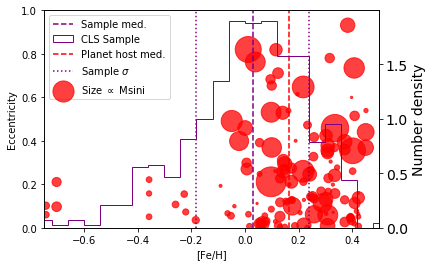

In [10]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ln1 = ax.scatter(good_spec_filter.fe, good_spec_filter.e, s=list(50*good_spec_filter.mass), 
                alpha=0.75, c='red', label=r'Size $\propto$ Msini')

#Accurately calculate median for planet hosts, don't duplicate metallicity for each planet.
unique_fe = np.unique(good_spec_filter.fe)
median_fe = np.median(unique_fe)
mad_fe = astrostats.mad_std(unique_fe)
ln2 = ax.axvline(x=median_fe, c='red', ls='--', label='Planet host med.')

ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Eccentricity')
ax.set_xlim([-0.75, 0.5])
ax.set_ylim([0, 1])

ax2 = ax.twinx()
ln3 = ax2.hist(fe_select, bins=40, histtype='step', color='purple', density=True, label='CLS Sample')
median_sample_fe = np.median(fe_select)
mad_sample_fe = astrostats.mad_std(fe_select)
ln4 = ax2.axvline(x=median_sample_fe, c='purple', ls='--', label='Sample med.')
ax.axvline(x=median_sample_fe+mad_sample_fe, c='purple', ls=':', label=r'Sample $\sigma$')
ax.axvline(x=median_sample_fe-mad_sample_fe, c='purple', ls=':')
ax2.set_ylabel('Number density')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2 + lines, labels2 + labels, loc=2, fontsize=10)

fig.savefig('plots/fe_eccentricity_hist.png', dpi=1000, bbox='tight')
fig.savefig('plots/fe_eccentricity_hist.pdf', bbox='tight')

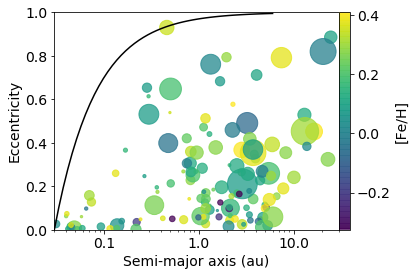

In [11]:
# Overplot peri-distance limit 0.03 AU.
axes = np.logspace(np.log10(0.03), np.log10(6))
e_max = 1 - 0.03/axes
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

im = ax.scatter(good_spec_filter.axis_med, good_spec_filter.e_med, s=list(50*good_spec_filter.mass), 
                c=good_spec_filter.fe_c, alpha=0.75, label=r'Size $\propto$ Msini')
ax.plot(axes, e_max, color='black', label=r'$e_{max}$ (0.03 AU)')
ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel('Eccentricity')
plt.colorbar(mappable=im, pad=0, label='[Fe/H]')

ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])

fig.savefig('plots/axis_eccentricity_metallicity.pdf', bbox_inches='tight')

## Compute median metallicity above and below 0.6 eccentricity.

In [12]:
np.median(good_spec_filter.query('e_med >= 0.6').fe_c)

0.104494328664

In [11]:
np.median(good_spec_filter.query('e_med < 0.6').fe_c)

0.197096382919

## Plot eccentricity with confidence intervals.

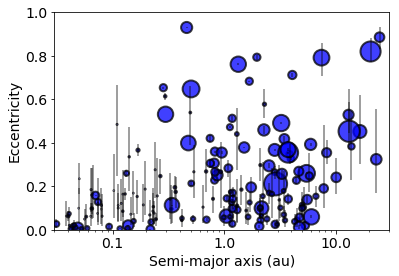

In [39]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(planets.axis_med, planets.e_med, 
           s=list(30*planets.mass), 
           c='blue', edgecolors='black', 
           alpha=0.75, linewidth=2,
           label=r'Size $\propto$ Msini')

# Differentiate between circular-consistent and eccentric-consistent.
ax.vlines(planets.axis_med, planets.e_minus,
          planets.e_plus, alpha=0.5, color='black')

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])

fig.savefig('plots/axis_eccentricity_ci.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/axis_eccentricity_ci.pdf', bbox_inches='tight')

## Separate singles and multis.

In [9]:
giants = planets.query('mass >= 0.1')
names = np.unique(giants.hostname)
singles = []
multis  = []
for name in names:
    if len(giants.query('hostname == @name')) == 1:
        singles.append(name)
    else:
        multis.append(name)
        
planets_single = giants.query('hostname in @singles')
planets_multi = giants.query('hostname in @multis')

In [33]:
len((planets_multi.hostname))

69

In [34]:
len(np.unique(planets_multi.hostname))

31

In [11]:
print(len(planets_single), len(planets_multi))

65 69


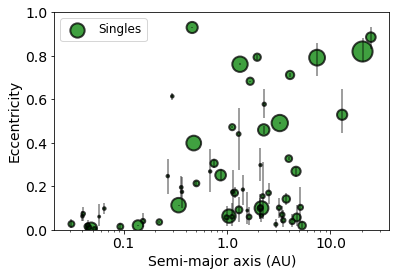

In [13]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(planets_single.axis_med, planets_single.e_med, 
           s=list(30*planets_single.mass), 
           c='green', edgecolors='black', 
           alpha=0.75, linewidth=2,
           label=r'Singles')

# Differentiate between circular-consistent and eccentric-consistent.
ax.vlines(planets_single.axis_med, planets_single.e_minus,
          planets_single.e_plus, alpha=0.5, color='black', label='__nolegend__')

ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
#ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])
ax.legend(fontsize=12)
#ax.set_xscale('log')
fig.savefig('plots/axis_eccentricity_singles.pdf', bbox='tight')

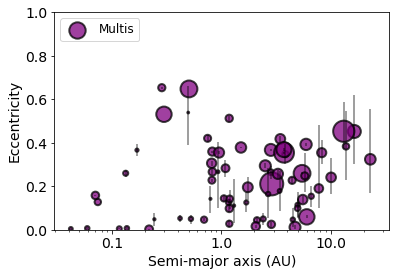

In [18]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(planets_multi.axis_med, planets_multi.e_med, 
           s=list(30*planets_multi.mass), 
           c='purple', edgecolors='black', 
           alpha=0.75, linewidth=2,
           label=r'Multis')

# Differentiate between circular-consistent and eccentric-consistent.
ax.vlines(planets_multi.axis_med, planets_multi.e_minus,
          planets_multi.e_plus, alpha=0.5, color='black', label='__nolegend__')

ax.set_xlabel('Semi-major axis (AU)')
ax.set_ylabel('Eccentricity')
#ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])
ax.legend(loc=2, fontsize=12)
#ax.set_xscale('log')
fig.savefig('plots/axis_eccentricity_multis.pdf', dpi=1000, bbox='tight')

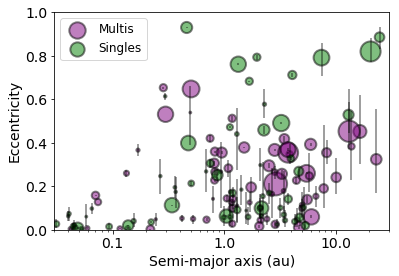

In [41]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(planets_multi.axis_med, planets_multi.e_med, 
           s=list(30*planets_multi.mass), 
           c='purple', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Multis')

# Differentiate between circular-consistent and eccentric-consistent.
ax.vlines(planets_multi.axis_med, planets_multi.e_minus,
          planets_multi.e_plus, alpha=0.5, color='black', label='__nolegend__')

ax.scatter(planets_single.axis_med, planets_single.e_med, 
           s=list(30*planets_single.mass), 
           c='green', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Singles')

# Differentiate between circular-consistent and eccentric-consistent.
ax.vlines(planets_single.axis_med, planets_single.e_minus,
          planets_single.e_plus, alpha=0.5, color='black', label='__nolegend__')

ax.legend(fontsize=12)

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel('Eccentricity')
ax.set_xlim([0.03, 30])
ax.set_ylim([0, 1])
fig.savefig('plots/axis_eccentricity_comparison.pdf', dpi=1000, bbox_inches='tight')

# Explore the population's eccentricity distribution.

## Fit Beta distribution to eccentricities. Define a likelihood function for the Beta distribution.

In [14]:
def beta(x, a, b):
    return spec.gamma(a+b)/(spec.gamma(a)*spec.gamma(b)) * x**(a-1) * (1-x)**(b-1)

def lnbetalike(theta, x, y, yerr):
    a, b = theta
    return -0.5*np.sum((y-beta(x, a, b))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

nll = lambda *args: -lnbetalike(*args)
# Kipping: a=0.867, b=3.03
def fit_beta(x, y, yerr, a_init=0.867, b_init=3.03): # Kipping estimates
    fit = op.minimize(nll, [a_init, b_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [76]:
e_pdf = np.histogram(planets.e, range=[0.001,1], density=True)
e_num = np.histogram(planets.e, range=[0.001,1], density=False)
print(e_pdf[0])

#yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
yerr = 0.1*np.ones(10)
fit = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit)

[3.18500319 2.67312767 1.53562654 1.19437619 0.45500046 0.34125034
 0.22750023 0.22750023 0.11375011 0.05687506]
[1.03725425 3.85110208]


## Explore Beta distribution posterior. NOT redrawing e's from posterior.

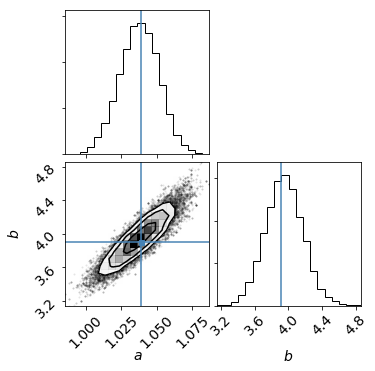

In [18]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] #1e-1

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnbetalike, args=(e_pdf[1][:-1], e_pdf[0], yerr,))
sampler.run_mcmc(pos, 500)

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$a$", "$b$"],
                      truths=[fit[0], fit[1]])
fig.savefig("analysis_plots/beta.pdf")

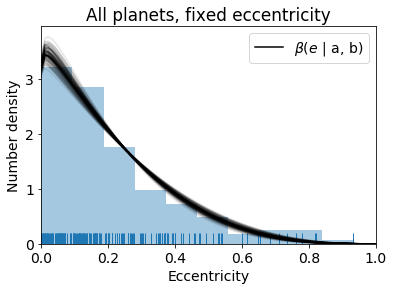

In [19]:
ax = sns.distplot(planets.e, bins=10, rug=True, norm_hist=True, kde=False)#, label=r'$\beta$')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title('All planets, fixed eccentricity')
ax.set_xlim([0,1])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
betas_fit = beta(es, fit[0], fit[1])
ax.plot(es, betas_fit, label=r'$\beta(e$ | a, b)', color='black')
for a, b in samples[np.random.randint(len(samples), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='black', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_histogram_beta_post_719.pdf')

## Repeat for half-Gaussian distribution.

In [11]:
def gauss(x, sig): # Defined for x >= 0 .
    return 2*np.exp(-(x/sig)**2)/np.sqrt(2*np.pi*sig**2)

def lngausslike(sig, x, y, yerr):
    return -0.5*np.sum((y-gauss(x, sig))**2*yerr**-2 + np.log(2*np.pi*yerr**2))

ngll = lambda *args: -lngausslike(*args)
def fit_gauss(x, y, yerr, sig_init=0.2): # Who knows?
    fit = op.minimize(ngll, [sig_init], args=(x, y, yerr),
                      method='Powell', options={'xtol': 1e-8, 'disp': True})
    return fit.x

In [21]:
#ygerr = np.sqrt(e_num[0])/np.sum(e_num[0]) #Poisson uncertainty
ygerr = 0.1*np.ones(10)
fitg = fit_gauss(e_pdf[1][:-1], e_pdf[0], yerr, sig_init=0.33)
print(fitg)

Optimization terminated successfully.
         Current function value: 4.483768
         Iterations: 2
         Function evaluations: 60
-0.2646530182096953


## Perform hierarchical inference. Use Legacy catalog eccentricity posteriors.

In [10]:
planets_noncirc = planets.query('axis > 0.3')
planets_big_noncirc = planets_noncirc.query('mass > 0.1')

In [80]:
def bound(array):
    return np.random.choice(array[(array > 0) & (array < 1)], 500)

# Generate a population, synthetic posteriors, based on real MAP values and CIs. 
masses_noncirc = planets.query('axis > 0.3')
e_minus = np.array(masses_noncirc.e_minus)
e_plus = np.array(masses_noncirc.e_plus)

posts = []
for i, e in enumerate(masses_noncirc.e):
    sig_e = 0.5*(e_plus[i] - e_minus[i])
    posts.append(bound(sig_e*np.random.randn(1000) + e))
posts = np.array(posts)

## Define the population likelihood for the beta distribution. Can generalize later.

In [11]:
def popprob(theta, samples):
    K = len(samples)    # Number of planets
    N = len(samples[0]) # Number of posterior samples
    
    sums = []
    for sample in samples:
        probs = beta(sample, theta[0], theta[1])
        sums.append(np.sum(probs)/N)
    return np.prod(sums) # *exp(−integral(Γ(e|θ)de)) (BUT THAT'S 1!)

def lnpoplike(theta, samples):
    #K = len(samples)
    N = len(samples[0])
    sums = []
    for sample in samples:
        probs = beta(sample, theta[0], theta[1])
        sums.append(np.sum(probs)/N)
    return np.sum(np.log(np.array(sums))) # Clean up N & K stuff

def lnpopprior(theta):
    #a, b = theta
    if 0 < theta[0] < 10 and 0 < theta[1] < 50:
        return 0.0
    else:
        return -np.inf

def lnpopprob(theta, samples):
    return lnpopprior(theta) + np.log(popprob(theta, samples))  #lnpoplike(theta, samples) 

In [83]:
e_pdf = np.histogram(masses_noncirc.e, range=[0.001,1], density=True)
e_num = np.histogram(masses_noncirc.e, range=[0.001,1], density=False)

yerr = np.sqrt(e_num[0])/np.sum(e_num[0]) # Poisson uncertainty
#yerr = 0.1*np.ones(10)
fit_noncirc = fit_beta(e_pdf[1][:-1], e_pdf[0], yerr, a_init=0.5, b_init=2.3)
print(fit_noncirc)

Optimization terminated successfully.
         Current function value: 393.525179
         Iterations: 22
         Function evaluations: 914
[1.09860989 4.15840171]


## Identify single- & multi-giant systems.

In [17]:
names = np.unique(planets_noncirc.hostname)
nplanets = np.array(planets_noncirc.groupby('hostname').count()['status'])
db_nplanets = pd.DataFrame({'hostname':names, 'nplanets':nplanets})

planets_noncirc = pd.merge(planets_noncirc, db_nplanets, on='hostname').reset_index()

## Separate planets by mass, boundary at Msini = 0.1 Mjup (see mass histograms below). Leave in the planets within 0.1 AU for now.

In [12]:
planets_big_all   = planets.query('mass > 0.1')
planets_small_all = planets.query('mass <= 0.1')
planets_big       = planets.query('mass > 0.1 and axis > 0.3')
planets_small     = planets.query('mass <= 0.1 and axis > 0.3')

### Add number of planets again, WITHIN each sample. Number of planets with Msini less than 0.1 MJup, and number of planets with Msini greater than 0.1 MJup.

In [17]:
names_big = np.unique(planets_big_all.hostname)
nplanets_big = np.array(planets_big_all.groupby('hostname').count()['status'])
db_nplanets_big = pd.DataFrame({'hostname':names_big, 'nplanets':nplanets_big})

names_small = np.unique(planets_small.hostname)
nplanets_small = np.array(planets_small.groupby('hostname').count()['status'])
db_nplanets_small = pd.DataFrame({'hostname':names_small, 'nplanets':nplanets_small})

planets_big   = pd.merge(planets_big, db_nplanets_big, on='hostname').reset_index()
planets_small = pd.merge(planets_small, db_nplanets_small, on='hostname').reset_index()

planets_big_all   = pd.merge(planets_big_all, db_nplanets_big, on='hostname').reset_index()
planets_small_all = pd.merge(planets_small_all, db_nplanets_small, on='hostname').reset_index()

### Split giant planets into single-giant, multi-giant.

In [13]:
planets_big_single = planets_big.query('nplanets == 1 and mass > 0.1').reset_index()
planets_big_multi  = planets_big.query('nplanets != 1 and mass > 0.1').reset_index()

UndefinedVariableError: name 'nplanets' is not defined

## Perform hierarchical inference with real posteriors.

### First, make re-sampled histogram of eccentricity posterior values. Do for all planets.

In [87]:
db_all = pd.read_csv('../legacy_samples/samples_all_joker.csv').sample(500)
#chains_26161 = pd.read_csv('../CLSI/Joker_results/26161_chains_combined.csv').sample(len(db_all))
#chains_213472 = pd.read_csv('../CLSI/Joker_results/213472_chains.csv').sample(len(db_all))
posts_all = []

for column in db_all.columns:
    if '_e' in column:
        posts_all.append(np.array(db_all[column]))
        nans = np.argwhere(np.isnan(db_all[column]))
        if len(nans) != 0:
            print(column)
        hist, bin_edges = np.histogram(db_all[column], bins=20, 
                                       range=(np.percentile(db_all[column], 2), 
                                              np.percentile(db_all[column], 98)))
        mode = bin_edges[np.argmax(hist)]
        if mode > 0.7:
            print(column, mode)
    
posts_all = np.array(posts_all)
#db_all = None
#chains_26161 = None
#chains_213472 = None

120066_e1 0.9406097640302611
181234_e1 0.8293424205713285
222582_e1 0.7608035764737778
26161_e1 0.7952677403432011
45350_e1 0.7873885452202887
80606_e1 0.930589142080941
87883_e1 0.7167601844956938


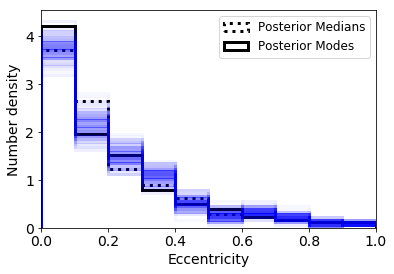

In [20]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

# Compute medians and approximate modes.
medians = np.median(posts_all, axis=1)
modes = []
for post in posts_all:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes.append(bin_edges[np.argmax(hist)])

ax.hist(medians, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', ls=':', alpha=1, label='Posterior Medians')
ax.hist(modes, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='black', alpha=1, label='Posterior Modes')

ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_xlim([0, 1])
#ax.set_ylim([0, 4.5])

for i in np.arange(len(posts_all)):
    dist = posts_all[:,i]
    ax.hist(dist, bins=10, density=True, histtype='step', 
        range = (0, 1), lw=3, color='blue', label='_nolegend_', alpha=0.03)
ax.legend(fontsize=12)

fig.savefig('analysis_plots/eccentricity_histogram_full.pdf', bbox_inches='tight')

In [88]:
db_big_noncirc = pd.read_csv('../legacy_samples/samples_big_noncirc_joker.csv').sample(500)
posts_big_noncirc = []

for column in db_big_noncirc.columns:
    if '_e' in column:
        posts_big_noncirc.append(np.array(db_big_noncirc[column]))
    
posts_big_noncirc = np.array(posts_big_noncirc)
db_big_noncirc = None

In [22]:
posts_big_noncirc

array([[0.1297554 , 0.27456644, 0.24904661, ..., 0.36623492, 0.24659271,
        0.28096073],
       [0.10156515, 0.09399618, 0.10057948, ..., 0.08989886, 0.10275797,
        0.10376877],
       [0.19263136, 0.02415968, 0.26036091, ..., 0.1345258 , 0.15458995,
        0.08206014],
       ...,
       [0.01951904, 0.3052857 , 0.34601056, ..., 0.12842681, 0.01769409,
        0.43446781],
       [0.37342824, 0.37458931, 0.37969021, ..., 0.38462532, 0.38033255,
        0.37645669],
       [0.05288854, 0.0537688 , 0.06452608, ..., 0.05425822, 0.0587345 ,
        0.05148531]])

### Make same histogram as full sample, for large & noncircular planets.

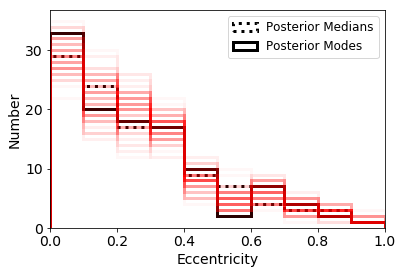

In [23]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

# Compute medians and approximate modes.
medians = np.median(posts_big_noncirc, axis=1)
big_noncirc_modes = []
for post in posts_big_noncirc:
    hist, bin_edges = np.histogram(post, bins=50, range=(np.percentile(post, 5), 
                                                         np.percentile(post, 95)))
    big_noncirc_modes.append(bin_edges[np.argmax(hist)])

ax.hist(medians, bins=10, density=False, histtype='step', range = (0, 1), 
        lw=3, color='black', ls=':', alpha=1, label='Posterior Medians')
ax.hist(big_noncirc_modes, bins=10, density=False, histtype='step', range = (0, 1), 
        lw=3, color='black', alpha=1, label='Posterior Modes')

ax.set(xlabel='Eccentricity', ylabel='Number')
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.3 AU')
ax.set_xlim([0, 1])

for i in np.arange(len(posts_big_noncirc)):
    dist = posts_big_noncirc[:,i]
    ax.hist(dist, bins=10, density=False, histtype='step', 
        range = (0, 1), lw=3, color='red', label='_nolegend_', alpha=0.03)
ax.legend(fontsize=12)

fig.savefig('analysis_plots/eccentricity_histogram_big_noncirc.pdf', dpi=1000, bbox_inches='tight')

In [37]:
lnpopprob(fit_noncirc, posts_big_noncirc)

24.970376190110947

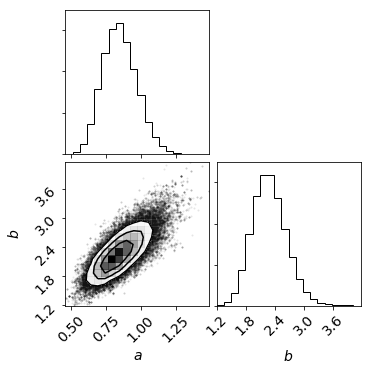

In [45]:
ndim, nwalkers = 2, 100
pos = [fit_noncirc + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_noncirc = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, #lnpoplike
                                           args=(posts_big_noncirc,))
sampler_big_noncirc.run_mcmc(pos, 1000, progress=True)

samples_big_noncirc = sampler_big_noncirc.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. 
a_big_noncirc_median = np.median(samples_big_noncirc[:, 0])
b_big_noncirc_median = np.median(samples_big_noncirc[:, 1])

fig = corner.corner(samples_big_noncirc, labels=["$a$", "$b$"])
fig.savefig("plots/corner_pop_big_noncirc.pdf", bbox_inches='tight')

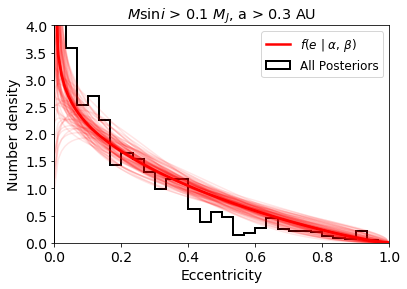

In [46]:
fig, ax = plt.subplots() #masses_big_noncirc.e
#ax.hist(big_noncirc_modes, bins=10, range=(0, 1),
#        density=True, histtype='step', lw=2, 
#        color='black', label='Posterior Modes')
ax.hist(posts_all.flatten(), bins=30, range=(0, 1),
        density=True, histtype='step', lw=2, 
        color='black', label='All Posteriors')

matplotlib.rcParams.update({'font.size': 12})
ax.set(xlabel='Eccentricity', ylabel='Number density')
matplotlib.rcParams.update({'font.size': 12})
ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.3 AU')
ax.set_xlim([0,1])
ax.set_ylim([0, 4])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_median = beta(es, a_big_noncirc_median, b_big_noncirc_median)

ax.plot(es, beta_median, label=r'$f(e$ | $\alpha$, $\beta$)', color='red', linewidth=2.5)
for a, b in samples_big_noncirc[np.random.randint(len(samples_big_noncirc), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='red', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('plots/eccentricity_pop_big_noncirc_real.pdf', bbox_inches='tight')

## Big singles & multis.

In [7]:
db_big_single = pd.read_csv('../legacy_samples/samples_big_single_noncirc_joker.csv').sample(500).reset_index(drop=True)
posts_big_single = []

for column in db_big_single.columns:
    if '_e' in column:
        hist, bin_edges = np.histogram(db_big_single[column], bins=20, range=(0, 1))
        mode = bin_edges[np.argmax(hist)]
        posts_big_single.append(np.array(db_big_single[column]))
        
        nans = np.argwhere(np.isnan(db_big_single[column]))
        if len(nans) != 0:
            print(column)
    
posts_big_single = np.array(posts_big_single[1:])    
db_big_single = None

100%|██████████| 1000/1000 [03:08<00:00,  5.31it/s]


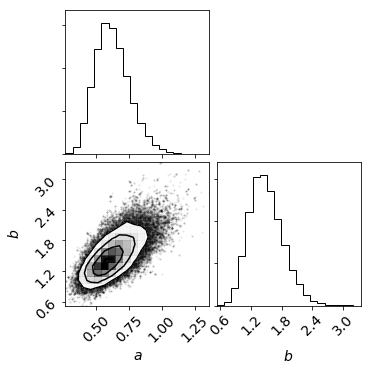

In [75]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_single = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_single,))
sampler_big_single.run_mcmc(pos, 1000, progress=True)

samples_big_single = sampler_big_single.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_single_median = np.median(samples_big_single[:, 0])
b_big_single_median = np.median(samples_big_single[:, 1])

fig = corner.corner(samples_big_single, labels=["$a$", "$b$"])
fig.savefig("plots/corner_pop_big_single_noncirc.pdf", bbox_inches='tight')

In [49]:
np.percentile(samples_big_single, [16, 50, 84], axis=0)

array([[0.49551204, 1.17180227],
       [0.61489916, 1.46761998],
       [0.75712503, 1.8118743 ]])

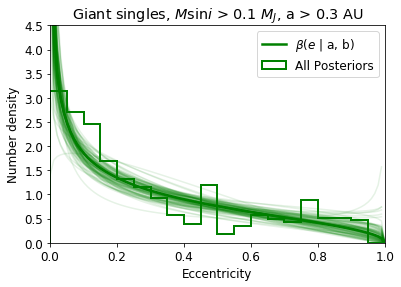

In [77]:
modes_single = []
for post in posts_big_single:
    hist, bin_edges = np.histogram(post, bins=20, range=(0, 1))
    modes_single.append(bin_edges[np.argmax(hist)])

fig, ax = plt.subplots()

#planets_big_single.e
#ax.hist(modes_single, bins=10, range=(0, 1), density=True, 
#        histtype='step', lw=2, color='green', label='Posterior Modes')
ax.hist(posts_big_single.flatten(), density=False,
        density=True, histtype='step', lw=2, 
        color='green', label='All Posteriors')
matplotlib.rcParams.update({'font.size': 12})
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.3 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4.5])

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_single_median = beta(es, a_big_single_median, 
                                  b_big_single_median)
ax.plot(es, beta_big_single_median, label=r'$\beta(e$ | a, b)', 
                                  color='green', linewidth=2.5)

for a, b in samples_big_single[np.random.randint(len(samples_big_single), 
                                                 size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='green', alpha=0.1)
ax.legend()
fig = ax.get_figure()
fig.savefig('plots/eccentricity_pop_big_single_noncirc.pdf', bbox_inches='tight')

In [8]:
db_big_multi = pd.read_csv('../legacy_samples/samples_big_multi_noncirc.csv').sample(1000)
posts_big_multi = []

for column in db_big_multi.columns:
    if '_e' in column:
        hist, bin_edges = np.histogram(db_big_multi[column], bins=20, range=(0, 1))
        mode = bin_edges[np.argmax(hist)]
        if column != '66428_e2': # NOT CHERRY-PICKING, JUST DEBUGGING
            posts_big_multi.append(np.array(db_big_multi[column]))
            if mode > 0.35:
                print(column)
    
posts_big_multi = np.array(posts_big_multi)
#db_big_multi = None

12661_e1
145675_e1
145675_e2
156279_e1
168443_e1
177830_e2
217107_e2
38529_e1
4203_e1
66428_e1
68988_e2
74156_e1
74156_e2
82943_e1
92788_e1
92788_e2
95128_e3
hip57050_e2
183263_e1


100%|██████████| 1000/1000 [05:11<00:00,  3.21it/s]


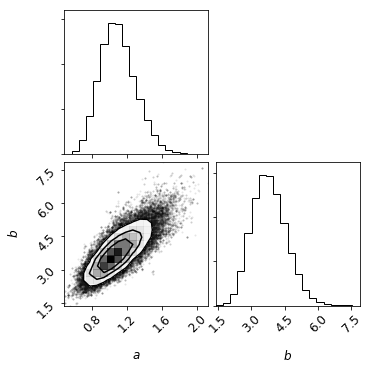

In [95]:
ndim, nwalkers = 2, 100
pos = [fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler_big_multi = emcee.EnsembleSampler(nwalkers, ndim, lnpopprob, 
                                           args=(posts_big_multi,))
sampler_big_multi.run_mcmc(pos, 1000, progress=True)

samples_big_multi = sampler_big_multi.chain[:, 100:, :].reshape((-1, ndim))
# Draw the median of the posterior. Or mode, stats.mode(samples_multi)
a_big_multi_median = np.median(samples_big_multi[:, 0])
b_big_multi_median = np.median(samples_big_multi[:, 1])

fig = corner.corner(samples_big_multi, labels=["$a$", "$b$"])
fig.savefig("plots/corner_pop_big_multi_noncirc.pdf")

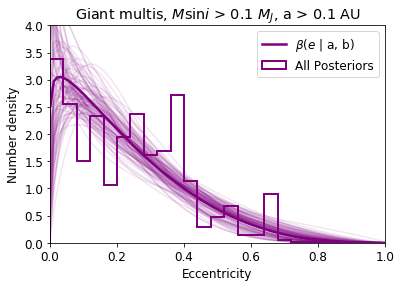

In [97]:
fig, ax = plt.subplots()

modes_multi = []
for post in posts_big_multi:
    hist, bin_edges = np.histogram(post, bins=30, range=(np.percentile(post, 2), 
                                                         np.percentile(post, 98)))
    modes_multi.append(bin_edges[np.argmax(hist)])

#planets_big_multi.e
#ax.hist(modes_multi, bins=10, range=(0,1), density=True, 
#        histtype='step', lw=2, color='purple', label='Posterior Modes')
ax.hist(posts_big_multi.flatten(), bins=25, range=(0, 1),
        density=True, histtype='step', lw=2, 
        color='purple', label='All Posteriors')
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_title(r'Giant multis, $M$sin$i$ > 0.1 $M_J$, a > 0.1 AU')
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
#'''
# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label=r'$\beta(e$ | a, b)', color='purple', linewidth=2.5)

for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)
#'''
ax.legend()
fig = ax.get_figure()
fig.savefig('analysis_plots/eccentricity_pop_big_multi_noncirc.png', dpi=1000, bbox_inches='tight')

## Nonparametrically test whether two eccentricity distributions are different.

In [19]:
# Compute medians and approximate modes.
medians_single = np.median(posts_big_single, axis=1)
medians_multi  = np.median(posts_big_multi, axis=1)

modes_single = []
modes_multi  = []

for post in posts_big_single:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes_single.append(bin_edges[np.argmax(hist)])
    
for post in posts_big_multi:
    hist, bin_edges = np.histogram(post, bins=100, range=(0, 1))
    modes_multi.append(bin_edges[np.argmax(hist)])
    

NameError: name 'posts_big_single' is not defined

In [10]:
integrals_single = []
integrals_multi  = []

all_single = []
all_multi  = []


for n in range(2000):
    eccys_single = []
    eccys_multi  = []

    for post in posts_big_single:
        eccys_single.append(np.random.choice(post))

    for post in posts_big_multi:
        eccys_multi.append(np.random.choice(post))
        
    integral_single = np.percentile(eccys_single, 84.1)
    integral_multi  = np.percentile(eccys_multi, 84.1)
    
    integrals_single.append(integral_single)
    integrals_multi.append(integral_multi)
    
    all_single.append(eccys_single)
    all_multi.append(eccys_multi)

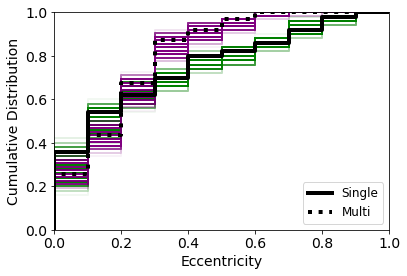

In [158]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

for thing in all_single:
    singlehist, single_edges = np.histogram(thing, normed=True, bins=10, range=(0, 1))
    singlechist = np.cumsum(singlehist)/np.sum(singlehist)
    x = np.vstack((single_edges, np.roll(single_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((singlechist, singlechist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

for thing in all_multi:
    multihist, multi_edges = np.histogram(thing, normed=True, bins=10, range=(0, 1))#bins=19
    multichist = np.cumsum(multihist)/np.sum(multihist)
    x = np.vstack((multi_edges, np.roll(multi_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((multichist, multichist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')
    
#modes_single = #[]
#modes_multi  = #[]

singlehist, single_edges = np.histogram(modes_single, normed=True, bins=10, range=(0, 1))
singlechist = np.cumsum(singlehist)/np.sum(singlehist)
x = np.vstack((single_edges, np.roll(single_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((singlechist, singlechist)).T.flatten(), 0, 0), 
        color='black', lw=4, alpha=1, label='Single')

multihist, multi_edges = np.histogram(modes_multi, normed=True, bins=10, range=(0, 1))
multichist = np.cumsum(multihist)/np.sum(multihist)
x = np.vstack((multi_edges, np.roll(multi_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((multichist, multichist)).T.flatten(), 0, 0), 
        color='black', ls=':', lw=4, alpha=1, label='Multi')  
    
#ax.set_xlabel(r'$e$')
ax.set_xlabel(r'Eccentricity')
ax.set_ylabel('Cumulative Distribution')

ax.legend(fontsize=12, loc=4)

fig.savefig('plots/eccentricity_cumulative_single_multi.pdf', bbox_inches='tight')

In [127]:
print(len(all_single), len(all_multi))

2000 2000


In [16]:
kolmogorovs = []
probs = []
for i in range(2000):
    singles = all_single[np.random.randint(0, len(all_single))]
    multis  = all_multi[np.random.randint(0, len(all_multi))]
    kolmogorov = scipy.stats.ks_2samp(singles, multis)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

In [133]:
darlings = []
dprobs = []
for i in range(2000):
    singles = all_single[i]
    multis  = all_multi[i]
    anderson = scipy.stats.anderson_ksamp([singles, multis])
    darlings.append(anderson[0])
    dprobs.append(anderson[2])

(-2.1, 0)

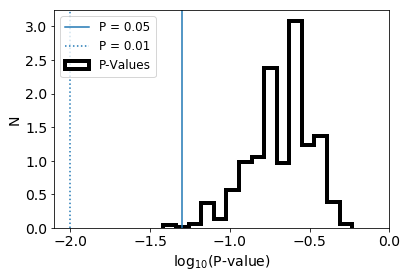

In [17]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ax.hist(np.log10(probs), bins=15, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')

ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.legend(loc=2, fontsize=12)
ax.set_xlim([-2.1, 0])
#fig.savefig('plots/ks_pvalue_lonely_pair.pdf', bbox_inches='tight')

(-2.1, 0)

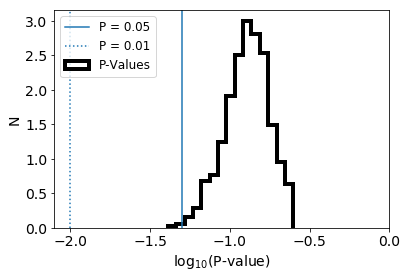

In [136]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
ax.hist(np.log10(dprobs), bins=15, histtype='step', density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')

ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.legend(loc=2, fontsize=12)
ax.set_xlim([-2.1, 0])
#fig.savefig('plots/ks_pvalue_lonely_pair.pdf', bbox_inches='tight')

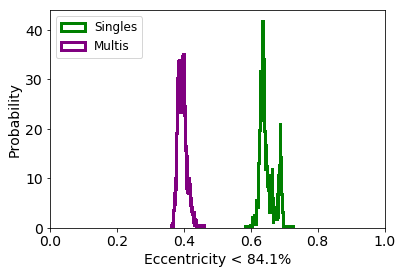

In [135]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_xlabel('Eccentricity < 84.1%')
ax.set_ylabel('Probability')

ax.hist(integrals_single, density=True, histtype='step',  
        bins=100, lw=3, color='green', alpha=1, label='Singles')
ax.hist(integrals_multi, density=True, histtype='step',  
        bins=100, lw=3, color='purple', alpha=1, label='Multis')

ax.legend(fontsize=12)

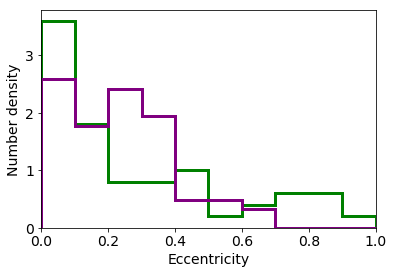

In [100]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.set(xlabel='Eccentricity', ylabel='Number density')
ax.set_xlim([0, 1])
    
ax.hist(modes_single, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='green', alpha=1, label='Posterior Modes')
ax.hist(modes_multi, bins=10, density=True, histtype='step', range = (0, 1), 
        lw=3, color='purple', alpha=1, label='Posterior Modes')
'''
for i in np.arange(len(posts_all)):
    dist = posts_all[:,i]
    ax.hist(dist, bins=10, density=True, histtype='step', 
        range = (0, 1), lw=3, color='blue', label='_nolegend_', alpha=0.03)
ax.legend(fontsize=12)
'''
fig.savefig('analysis_plots/eccentricity_nonparametric_comparison.pdf', bbox_inches='tight')

## Make single/multi comparison plot for beta distributions.

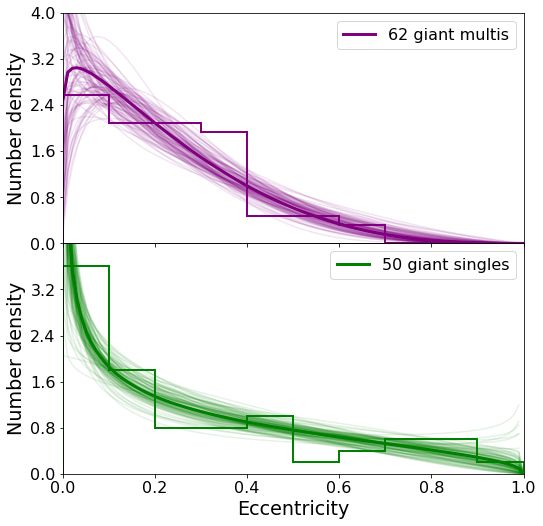

In [101]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(8, 8))

nsingle = len(posts_big_single)
nmulti  = len(posts_big_multi)

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.4])
ax1.set_xlabel('Eccentricity', fontsize='large')
ax1.set_ylabel('Number density', fontsize='large')
#ax1.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.3 AU', fontsize='x-large')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 4])

# Plot histogram of singles. planets_big_single.e
ax1.hist(modes_single, bins=10, density=True, range = (0, 1),
         histtype='step', lw=2, color='green', label='_nolegend_')

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax1.plot(es, beta_big_single_median, label=r'{} giant singles > 0.3 au'.format(nsingle), 
         color='green', linewidth=3)

for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax1.plot(es, betas, c='green', alpha=0.1)
ax1.legend(fontsize=16)

# Remove topmost tick mark from bottom panel.
nbins = len(ax1.get_xticklabels()) # added 
ax1.yaxis.set_major_locator(MaxNLocator(nbins=nbins, prune='upper'))

ax2 = fig.add_axes([0.1, 0.5, 0.8, 0.4])
ax2.set_ylabel('Number density', fontsize='large')
#ax2.set_title(r'Giant singles, $M$sin$i$ > 0.1 $M_J$, a > 0.3 AU', fontsize='x-large')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 4])
#planets_big_multi.e
ax2.hist(modes_multi, bins=10, density=True, range = (0, 1),
         histtype='step', lw=2, color='purple', label='_nolegend_')
#label=r'$\beta(e$ | a, b)'

# Overplot Beta fit distribution, draw from samples.
es = np.linspace(0.001, 1, num=100)
beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax2.plot(es, beta_big_multi_median, label=r'{} giant multis > 0.3 au'.format(nmulti), 
         color='purple', linewidth=3)
ax2.set_xticklabels('')

for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax2.plot(es, betas, c='purple', alpha=0.1)
ax2.legend(fontsize=16)

ax2.yaxis.set_major_locator(MaxNLocator(nbins=nbins))

#fig.savefig('plots/eccentricity_pop_hist_comparison.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/eccentricity_pop_hist_comparison.pdf', bbox_inches='tight')

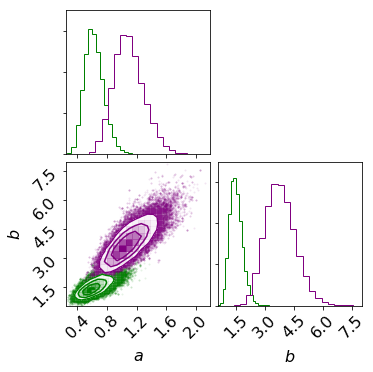

In [102]:
## Plot the two distributions on top of each other.
fig = corner.corner(samples_big_single, labels=["$a$", "$b$"], color='green')#, quantiles=[0.16, 0.5, 0.84])
corner.corner(samples_big_multi, fig=fig, color='purple')#, quantiles=[0.16, 0.5, 0.84])
# Histogram limits.
fig.axes[0].set_xlim([0.25, 2.2])
fig.axes[0].set_ylim([0, 1.75*10**4])
fig.axes[3].set_xlim([0.55, 8])
fig.axes[3].set_ylim([0, 1.75*10**4])
# Scatterplot limits.
fig.axes[2].set_xlim([0.25, 2.2])
fig.axes[2].set_ylim([0.55, 8])
# Plots to clarify.
#fig.axes[0].set_title(r'$M$sin$i$ > 0.1 $M_J$' + ' \na > 0.1 AU')
#fig.axes[3].set_title('Green: singles \nPurple: multis')
fig.savefig("plots/corner_real_big_noncirc_comparison_new.pdf", bbox_inches='tight')

(array([2.9236, 2.0772, 1.2352, 0.7564, 0.7956, 0.266 , 0.534 , 0.6628,
        0.5116, 0.2376]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 1 Patch objects>)

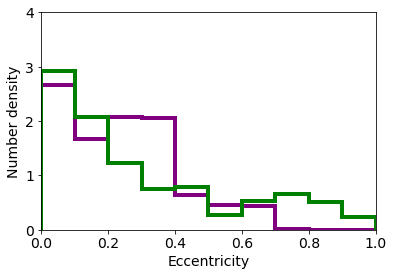

In [103]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')

ax.hist(posts_big_multi.flatten(), bins=10, range=(0, 1),
        density=True, histtype='step', lw=4, 
        color='purple', label='Multi Posteriors')
ax.hist(posts_big_single.flatten(), bins=10, range=(0, 1),
        density=True, histtype='step', lw=4, 
        color='green', label='Multi Posteriors')

## See how many multis would have to scatter to produce the single tail.

In [64]:
len(np.unique(planets.query('mass <= 0.1 and axis < 0.3').hostname))

26

In [61]:
print(len(np.unique(planets_big_single.hostname)), len(np.unique(planets_big_multi.hostname)))

49 30


In [67]:
len(planets.query('mass >= 30/317.8'))
#len(planets.query('mass >= 0.1'))

134

In [74]:
len(np.unique(planets_big_multi.query('axis > 0.3').hostname))

30

In [60]:
print(len(np.unique(planets_big_single.query('e > 0.5').hostname)))

11


### About a fifth of multis would have to scatter to produce this result.

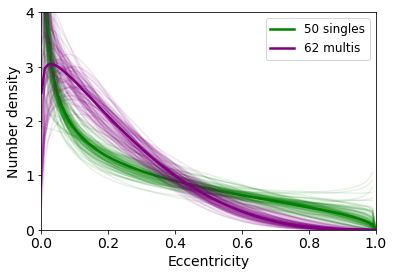

In [107]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 4])
ax.set(xlabel='Eccentricity', ylabel='Number density')
#ax.set_title(r'$M$sin$i$ > 0.1 $M_J$, a > 0.3 AU')

nsingle = len(posts_big_single)
nmulti  = len(posts_big_multi)

# Overplot Beta fit distribution, single median and many drawn from samples.
es = np.linspace(0.001, 1, num=100)

beta_big_single_median = beta(es, a_big_single_median, b_big_single_median)
ax.plot(es, beta_big_single_median, label='{} singles'.format(nsingle), color='green', linewidth=2.5)
for a, b in samples_big_single[np.random.randint(len(samples_big_single), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='g', alpha=0.1)

beta_big_multi_median = beta(es, a_big_multi_median, b_big_multi_median)
ax.plot(es, beta_big_multi_median, label='{} multis'.format(nmulti), color='purple', linewidth=2.5)
for a, b in samples_big_multi[np.random.randint(len(samples_big_multi), size=100)]:
    betas = beta(es, a, b)
    ax.plot(es, betas, c='purple', alpha=0.1)

ax.legend(fontsize=12)
#fig.savefig('plots/eccentricity_real_comparison_beta_big_noncirc.png', dpi=1000, bbox_inches='tight')
fig.savefig('plots/eccentricity_real_comparison_beta_big_noncirc.pdf', bbox_inches='tight')

## Look at multi stats for the whole sample, and for giants.

In [14]:
names = np.unique(planets.query('mass >= 0.1 and hostname != "143761"').hostname)
multistats = []
singlenames = []
multinames = []
giantnames = []
singlecircnames = []
singleeccnames  = []
hotnames  = []
coldnames = []

bad_names = ['114762', '143761', '28185', '42581', \
              '8375', '72659', '167215']

for name in names:
    sample = planets.query('mass >= 0.1 and hostname == @name')
    ngiants = len(sample)
    if ngiants >= 1:
        giantnames.append(name)
    multistats.append(ngiants)
    
    if ngiants == 1:
        singlenames.append(name)
        if np.array(planets.query('mass >= 0.1 and hostname == @name').e)[0] < 0.2:
            singlecircnames.append(name)
        else:
            singleeccnames.append(name)
    elif ngiants > 1:
        multinames.append(name)
    else:
        pass
    
    for axis in list(sample.axis):
        if axis <= 0.1:
            hotnames.append(name)
        else:coldnames.append(name)
            
hotnames = np.unique(hotnames)
coldnames = np.unique(coldnames)

In [11]:
print(len(singlecircnames), len(singleeccnames))

38 26


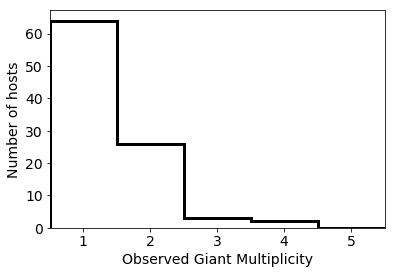

In [113]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(multistats, color='black', histtype='step', lw=3, range=(0.5, 5.5), bins=5)
ax.set_xlim([0.5, 5.5])
ax.set_xlabel('Observed Giant Multiplicity')
ax.set_ylabel('Number of hosts')
fig.savefig('plots/observed_giant_multiplicity.pdf', bbox_inches='tight')

## Make log-axis ratio for two-planet systems.

In [11]:
logratios = []
for index, name in enumerate(giantnames):
    if multistats[index] == 2:
        pair = planets.query('mass >= 0.1 and hostname == @name')
        logratios.append(np.log10(np.amax(pair.axis)) - np.log10(np.amin(pair.axis)))

In [13]:
len(logratios)

26

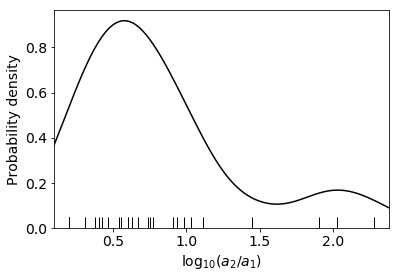

In [25]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()
ax.set_xlim([np.amin(logratios) - 0.1, np.amax(logratios) + 0.1])
ax.set_xlabel(r'log$_{10}$($a_2/a_1$)')
ax.set_ylabel(r'Probability density')
sns.distplot(logratios, rug=True, hist=False, kde=True, ax=ax, color='black')
fig.savefig('plots/observed_axis_ratios.pdf', bbox_inches='tight')

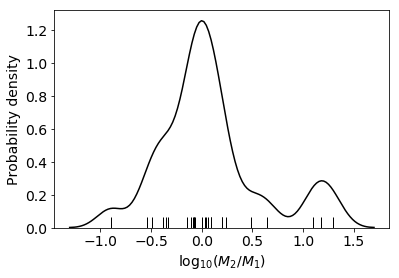

In [33]:
logmassratios = []
for index, name in enumerate(giantnames):
    if multistats[index] == 2:
        pair = planets.query('mass >= 0.1 and hostname == @name')
        logmassratios.append(np.log10(np.array(pair.mass)[0]) - \
                             np.log10(np.array(pair.mass)[1]))

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()
#ax.set_xlim([np.amin(logmassratios) - 0.1, np.amax(logmassratios) + 0.1])
ax.set_xlabel(r'log$_{10}$($M_2/M_1$)')
ax.set_ylabel(r'Probability density')
sns.distplot(logmassratios, rug=True, hist=False, kde=True, ax=ax, color='black')
fig.savefig('plots/observed_mass_ratios.pdf', bbox_inches='tight')

Text(0, 0.5, 'M2 (MJup)')

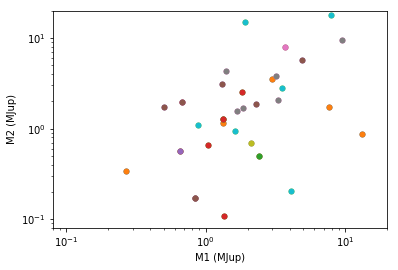

In [20]:
fig, ax = plt.subplots()
pairs = planets.query('mass >= 0.1 and hostname in @multinames')
for hostname in pairs.hostname:
    ax.scatter(np.array(pairs.query('hostname==@hostname').mass)[0], 
               np.array(pairs.query('hostname==@hostname').mass)[1])
    
ax.set_xlim([0.08, 20])
ax.set_ylim([0.08, 20])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('M1 (MJup)')
ax.set_ylabel('M2 (MJup)')

## Compare metallicity distributions of single-giant and multi-giant hosts.

In [12]:
ghosts  = specmatch.query('name in @giantnames and name != "143761"')
sghosts = specmatch.query('name in @singlenames and name != "143761"')
mghosts = specmatch.query('name in @multinames and name != "143761"')
nghosts = specmatch.query('name not in @giantnames and name != "143761"')

scghosts = specmatch.query('name in @singlecircnames and name != "143761"')
seghosts = specmatch.query('name in @singleeccnames and name != "143761"')

hghosts = specmatch.query('name in @hotnames and name != "143761"')
cghosts = specmatch.query('name in @coldnames and name != "143761"')

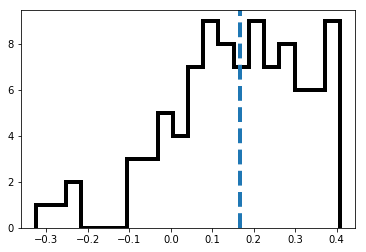

In [22]:
fig, ax = plt.subplots()
ax.hist(ghosts.fe_c, bins=20, histtype='step', lw=4, color='black')
ax.axvline(np.median(ghosts.fe_c),  lw=4, ls='--')

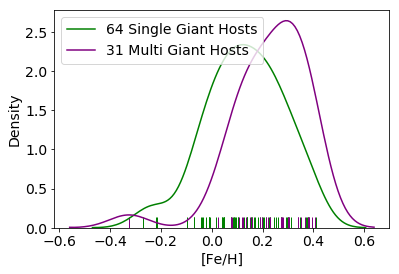

In [43]:
fig, ax = plt.subplots()

sns.distplot(sghosts.fe_c, rug=True, hist=False, kde=True, ax=ax, color='green', \
             label='{} Single Giant Hosts'.format(len(sghosts)))
sns.distplot(mghosts.fe_c, rug=True, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Multi Giant Hosts'.format(len(mghosts)))

ax.set_xlim([-0.5, 0.42])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Density')
ax.legend(loc=2)
fig.savefig('plots/single_multi_giant_fe_histogram.pdf')
fig.savefig('plots/single_multi_giant_fe_histogram.png', bbox_inches='tight', dpi=1000)

In [17]:
sghosts.query('fe_c < -0.1')[['name', 'fe_c']]

,name,fe_c
40,114729,-0.272001
93,136925,-0.217220
395,4208,-0.220051


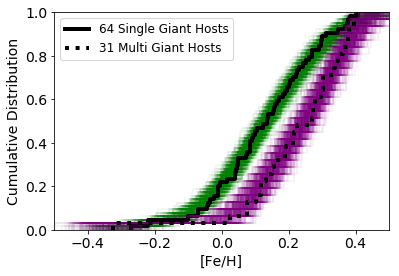

In [118]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

for i in np.arange(500):
    metals = np.random.normal(sghosts.fe_c, sghosts.fe_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=5*len(sghosts))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(sghosts.fe_c, normed=True, bins=5*len(sghosts))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single Giant Hosts'.format(len(sghosts)))


for i in np.arange(500):
    metals = np.random.normal(mghosts.fe_c, mghosts.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True, bins=5*len(mghosts))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(mghosts.fe_c, normed=True, bins=5*len(mghosts))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Multi Giant Hosts'.format(len(mghosts)))


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/single_multi_giant_fe_cumulative.pdf', bbox_inches='tight')
#fig.savefig('plots/single_multi_giant_fe_cumulative.png', bbox_inches='tight', dpi=1000)

In [40]:
darlings = []
dprobs = []
for i in np.arange(10**5):
    solometals = np.random.normal(sghosts.fe_c, sghosts.fe_err_c)
    multimetals = np.random.normal(mghosts.fe_c, mghosts.fe_err_c)
    anderson = scipy.stats.anderson_ksamp([solometals, multimetals])
    darlings.append(anderson[0])
    dprobs.append(anderson[2])

In [45]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    solometals = np.random.normal(sghosts.fe_c, sghosts.fe_err_c)
    multimetals = np.random.normal(mghosts.fe_c, mghosts.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(solometals, multimetals)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

In [31]:
print(scipy.stats.percentileofscore(probs, 0.05), scipy.stats.percentileofscore(probs, 0.01))

92.236 53.236


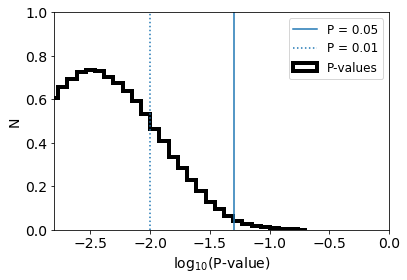

In [46]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(np.log10(dprobs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-2.8, 0])
ax.set_ylim([0, 1])
ax.legend(fontsize=12)
fig.savefig('plots/ad_pvalue_single_multi_metals.pdf', bbox_inches='tight')

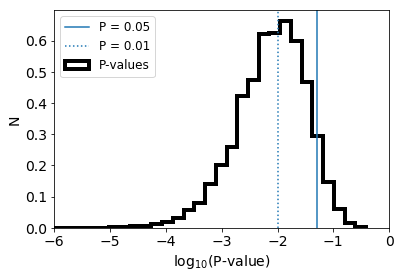

In [51]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(np.log10(probs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-6, 0])
ax.legend(fontsize=12)
fig.savefig('plots/ks_pvalue_single_multi_metals.pdf', bbox_inches='tight')

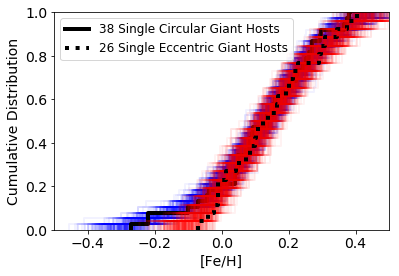

In [95]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

for i in np.arange(500):
    metals = np.random.normal(scghosts.fe_c, scghosts.fe_err_c)
    circhist, circ_edges = np.histogram(metals, normed=True, bins=5*len(scghosts))
    circchist = np.cumsum(circhist)/np.sum(circhist)
    x = np.vstack((circ_edges, np.roll(circ_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((circchist, circchist)).T.flatten(), 0, 0), 
            color='blue', lw=2, alpha=0.05, label='_nolegend_')    

circhist, circ_edges = np.histogram(scghosts.fe_c, normed=True, bins=5*len(scghosts))
circchist = np.cumsum(circhist)/np.sum(circhist)
x = np.vstack((circ_edges, np.roll(circ_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((circchist, circchist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single Circular Giant Hosts'.format(len(scghosts)))


for i in np.arange(500):
    metals = np.random.normal(seghosts.fe_c, seghosts.fe_err_c)
    ecchist, ecc_edges = np.histogram(metals, normed=True, bins=5*len(seghosts))
    eccchist = np.cumsum(ecchist)/np.sum(ecchist)
    x = np.vstack((ecc_edges, np.roll(ecc_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((eccchist, eccchist)).T.flatten(), 0, 0), 
            color='red', lw=2, alpha=0.05, label='_nolegend_')    
    
ecchist, ecc_edges = np.histogram(seghosts.fe_c, normed=True, bins=5*len(seghosts))
eccchist = np.cumsum(ecchist)/np.sum(ecchist)
x = np.vstack((ecc_edges, np.roll(ecc_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((eccchist, eccchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Single Eccentric Giant Hosts'.format(len(seghosts)))


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/single_circ_ecc_cumulative.pdf', bbox_inches='tight')
fig.savefig('plots/single_circ_ecc_cumulative.png', bbox_inches='tight', dpi=1000)

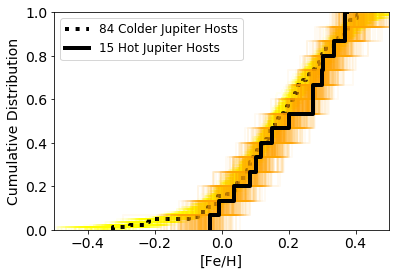

In [96]:
fig, ax = plt.subplots()

for i in np.arange(500):
    metals = np.random.normal(cghosts.fe_c, cghosts.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True, bins=5*len(cghosts))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='yellow', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(cghosts.fe_c, normed=True, bins=5*len(cghosts))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Colder Jupiter Hosts'.format(len(cghosts)))

for i in np.arange(500):
    metals = np.random.normal(hghosts.fe_c, hghosts.fe_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=5*len(hghosts))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='orange', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(hghosts.fe_c, normed=True, bins=5*len(hghosts))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Hot Jupiter Hosts'.format(len(hghosts)))

ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H]')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/hot_cold_giant_fe_cumulative.pdf', bbox_inches='tight')
fig.savefig('plots/hot_cold_giant_fe_cumulative.png', bbox_inches='tight', dpi=1000)

## Merge single giant planet properties with specmatch table.

In [14]:
merge_columns = list(planets.columns)
merge_columns.append('fe_c')
m_good_spec = pd.DataFrame(columns=merge_columns)

planets['name'] = planets['hostname']
single_spec = pd.merge(planets.query('hostname in @singlenames'), sghosts, on=['name'])
multi_spec  = pd.merge(planets.query('hostname in @multinames'), mghosts, on=['name'])
none_spec   = pd.merge(planets.query('hostname not in @giantnames'), nghosts, on=['name'])

Text(0, 0.5, '$e$')

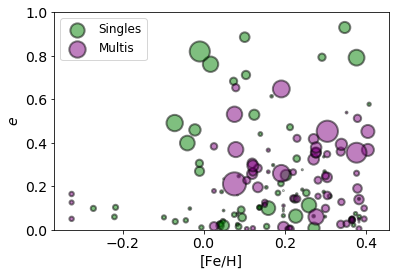

In [63]:
fig, ax = plt.subplots()

ax.scatter(single_spec.fe_c, single_spec.e_med, 
           s=list(30*single_spec.mass), 
           c='green', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Singles')

ax.scatter(multi_spec.fe_c, multi_spec.e_med, 
           s=list(30*multi_spec.mass), 
           c='purple', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Multis')

ax.set_ylim([0, 1])
ax.legend(fontsize=12)

ax.set_xlabel('[Fe/H]')
ax.set_ylabel(r'$e$')

In [60]:
multi_spec.query('axis < 0.06')

,Unnamed: 0_x,hostname,status,pl_index,mass,mass_med,mass_minus,mass_plus,axis,axis_med,...,logg_c,logg_err_c,radius_c,radius_err_c,mass_c,mass_err_c,index_y,star,mv,bvcolor
24,107,187123,K,1.0,0.500667,0.500908,0.485032,0.516744,0.041856,0.041856,...,4.319755,0.031995,1.154992,0.027183,1.020234,0.047963,253,187123,4.457612,0.61
46,241,75732,K,5.0,0.029567,0.029471,0.028115,0.030834,0.015826,0.015826,...,4.458131,0.031660,0.964411,0.020816,0.974708,0.045056,539,75732,5.460014,0.87
54,279,9826,K,1.0,0.674950,0.675053,0.659440,0.690768,0.059136,0.059137,...,4.125176,0.024844,1.622479,0.038881,1.294197,0.041225,596,9826,3.453482,0.54


### Split singles & multis along distance axis. Visualize first, then split at arbitrary point, then move on from there.

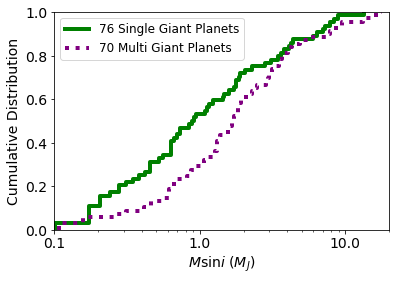

In [89]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

solohist, solo_edges = np.histogram(single_spec.query('mass >= 0.1').mass, normed=True, bins=5*len(single_spec))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='green', lw=4,
        label='{} Single Giant Planets'.format(len(single_spec)))

pairhist, pair_edges = np.histogram(multi_spec.query('mass >= 0.1').mass, normed=True, bins=5*len(multi_spec))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='purple', 
        lw=4, ls=':', label='{} Multi Giant Planets'.format(len(multi_spec)))

ax.set_xlabel(r'$M$sin$i$ $(M_J)$')
ax.set_ylabel('Cumulative Distribution')
ax.set_ylim([0, 1])
ax.set_xlim([0.1, 20])
ax.legend(fontsize=12)

Text(0.5, 0, 'log$_{10}$($M$sin$i/M_J)$')

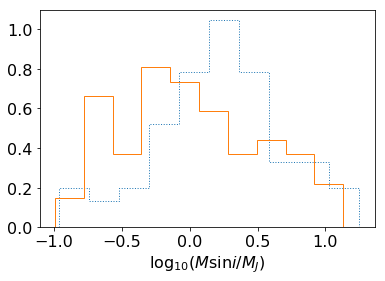

In [35]:
fig, ax = plt.subplots()
ax.hist(np.log10(multi_spec.query('mass >= 0.1').mass), density=True, ls=':', histtype='step')
ax.hist(np.log10(single_spec.query('mass >= 0.1').mass), density=True, histtype='step')
ax.set_xlabel(r'log$_{10}$($M$sin$i/M_J)$')

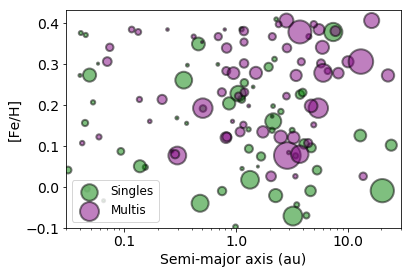

In [94]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(single_spec.query('mass >= 0.1').axis_med, single_spec.query('mass >= 0.1').fe_c, 
           s=list(40*single_spec.query('mass >= 0.1').mass), 
           c='green', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Singles')

ax.scatter(multi_spec.query('mass >= 0.1').axis_med, multi_spec.query('mass >= 0.1').fe_c, 
           s=list(40*multi_spec.query('mass >= 0.1').mass), 
           c='purple', edgecolors='black', 
           alpha=0.5, linewidth=2,
           label='Multis')

ax.legend(fontsize=12)

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([0.03, 30])
ax.set_ylim([-0.1, 0.43])
fig.savefig('plots/axis_metallicity_comparison.pdf', bbox_inches='tight')

In [15]:
single_spec_close = single_spec.query('axis < 1')
multi_spec_close  = multi_spec.query('axis < 1')
single_spec_far   = single_spec.query('axis >= 1')
multi_spec_far    = multi_spec.query('axis >= 1')

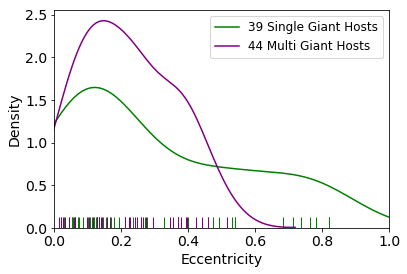

In [51]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

sns.distplot(single_spec_far.e, rug=True, hist=False, kde=True, ax=ax, color='green', \
             label='{} Single Giant Hosts'.format(len(single_spec_far)))
sns.distplot(multi_spec_far.e, rug=True, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Multi Giant Hosts'.format(len(multi_spec_far)))

ax.set_xlim([0, 1])
ax.set_xlabel('Eccentricity')
ax.set_ylabel('Density')
ax.legend(loc=1, fontsize=12)
fig.savefig('plots/single_multi_giant_ecc_histogram.pdf', bbox_inches='tight')
#fig.savefig('plots/single_multi_giant_ecc_histogram.png', bbox_inches='tight', dpi=1000)

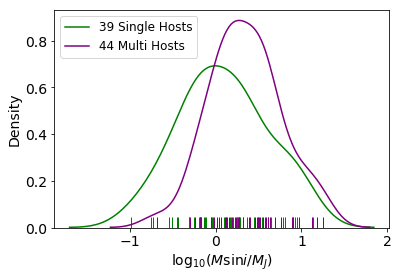

In [59]:
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots()

sns.distplot(np.log10(single_spec_far.mass), rug=True, hist=False, kde=True, ax=ax, color='green', \
             label='{} Single Hosts'.format(len(single_spec_far)))
sns.distplot(np.log10(multi_spec_far.mass), rug=True, hist=False, kde=True, ax=ax, color='purple', \
             label='{} Multi Hosts'.format(len(multi_spec_far)))

#ax.set_xlim([0, 1])
ax.set_xlabel(r'log$_{10}(M$sin$i/M_J$)')
ax.set_ylabel('Density')
ax.legend(loc=2, fontsize=12)
fig.savefig('plots/single_multi_giant_msini_histogram.pdf', bbox_inches='tight')
#fig.savefig('plots/single_multi_giant_ecc_histogram.png', bbox_inches='tight', dpi=1000)

In [125]:
print(len(single_spec_close), len(multi_spec_close), len(single_spec_far), len(multi_spec_far))

37 26 39 44


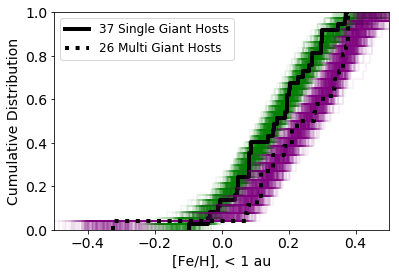

In [35]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

for i in np.arange(500):
    metals = np.random.normal(single_spec_close.fe_c, single_spec_close.fe_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=5*len(single_spec_close))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(single_spec_close.fe_c, normed=True, bins=5*len(single_spec_close))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single Giant Hosts'.format(len(single_spec_close)))


for i in np.arange(500):
    metals = np.random.normal(multi_spec_close.fe_c, multi_spec_close.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True, bins=5*len(multi_spec_close))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(multi_spec_close.fe_c, normed=True, bins=5*len(multi_spec_close))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Multi Giant Hosts'.format(len(multi_spec_close)))


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H], < 1 au')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/single_multi_giant_close_fe_cumulative.pdf', bbox_inches='tight')

In [134]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    solometals = np.random.normal(single_spec_close.fe_c, single_spec_close.fe_err_c)
    multimetals = np.random.normal(multi_spec_close.fe_c, multi_spec_close.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(solometals, multimetals)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

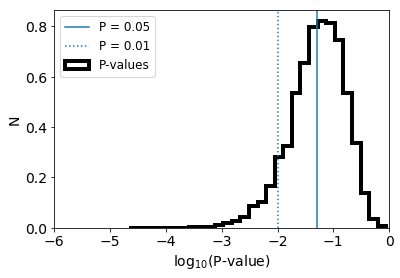

In [137]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(np.log10(probs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-6, 0])
ax.legend(fontsize=12)
fig.savefig('plots/ks_pvalue_single_multi_close_metals.pdf', bbox_inches='tight')

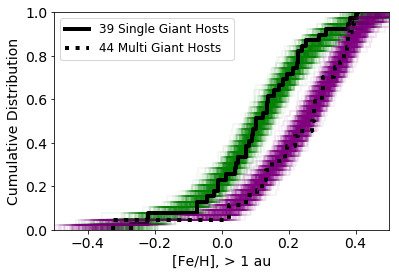

In [37]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

for i in np.arange(500):
    metals = np.random.normal(single_spec_far.fe_c, single_spec_far.fe_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=5*len(single_spec_far))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(single_spec_far.fe_c, normed=True, bins=5*len(single_spec_far))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single Giant Hosts'.format(len(single_spec_far)))


for i in np.arange(500):
    metals = np.random.normal(multi_spec_far.fe_c, multi_spec_far.fe_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True, bins=5*len(multi_spec_far))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(multi_spec_far.fe_c, normed=True, bins=5*len(multi_spec_far))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Multi Giant Hosts'.format(len(multi_spec_far)))


ax.set_xlim([-0.5, 0.5])
ax.set_ylim([0., 1.0])
ax.set_xlabel('[Fe/H], > 1 au')
ax.set_ylabel('Cumulative Distribution')
ax.legend(fontsize=12)

fig.savefig('plots/single_multi_giant_far_fe_cumulative.pdf', bbox_inches='tight')

In [138]:
kolmogorovs = []
probs = []
for i in np.arange(10**5):
    solometals = np.random.normal(single_spec_far.fe_c, single_spec_far.fe_err_c)
    multimetals = np.random.normal(multi_spec_far.fe_c, multi_spec_far.fe_err_c)
    kolmogorov = scipy.stats.ks_2samp(solometals, multimetals)
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

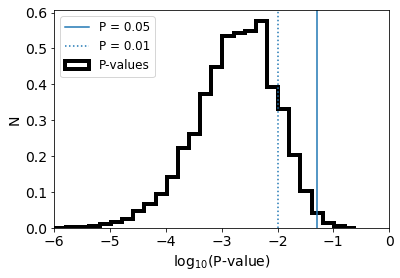

In [139]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(np.log10(probs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value)')
ax.set_ylabel('N')
ax.set_xlim([-6, 0])
ax.legend(fontsize=12)
fig.savefig('plots/ks_pvalue_single_multi_far_metals.pdf', bbox_inches='tight')

In [17]:
# 114762 is already listed as a binary, but drop it from the combined list. Also drop bad binary residual fits.
bad_names = ['114762', '143761', '28185', '42581', \
              '8375', '72659', '167215'] # 167215 has a good eccentric binary, and a circular wobble we can't fit out.
objects_good['name'] = objects_good['hostname']
total_spec = pd.merge(objects_good, specmatch, on=['name']).query('fe_c > -0.6 and name not in @bad_names')

In [49]:
with open('names_giant_single.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in singlenames:
        if name not in bad_names:
            writer.writerow([val])

with open('names_giant_multi.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in multinames:
        if name not in bad_names:
            writer.writerow([val])

In [22]:
median_fe_giant = np.median(ghosts.fe_c)
poornames = np.unique(ghosts.query('fe_c <= @median_fe_giant').name)
richnames = np.unique(ghosts.query('fe_c > @median_fe_giant').name)

In [19]:
with open('names_giant_poor.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in poornames:
        writer.writerow([val])

with open('names_giant_rich.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['name'])
    for val in richnames:
        writer.writerow([val])

## Compare completeness of single-found giant and multi-found giant systems.

In [17]:
recoveries_gpoor = pd.read_csv('../recovery_files/recoveries_giant_poor_earth.csv')
completey_gpoor  = Completeness(recoveries_gpoor)
completey_gpoor.completeness_grid([0.01, 40], [2, 9000])

recoveries_grich = pd.read_csv('../recovery_files/recoveries_giant_rich_earth.csv')
completey_grich  = Completeness(recoveries_grich)
completey_grich.completeness_grid([0.01, 40], [2, 9000])

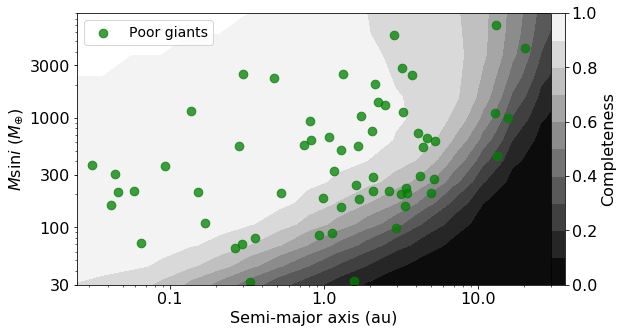

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 16})

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.set_yticks((30, 100, 300, 1000, 3000))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_gpoor.grid[0], completey_gpoor.grid[1],
                 completey_gpoor.grid[2], 10, cmap=plt.cm.gray)

ax.scatter(total_spec.query('fe_c <= @median_fe_giant').axis, 
           317.8*total_spec.query('fe_c <= @median_fe_giant').mass, 
           c='g', s=75, alpha=0.75, label='Poor giants')

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([30, 9000])

ymin, ymax = ax.get_ylim()

ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(fontsize=14)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/contours_giant_poor.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/contours_giant_poor.pdf', bbox_inches='tight')

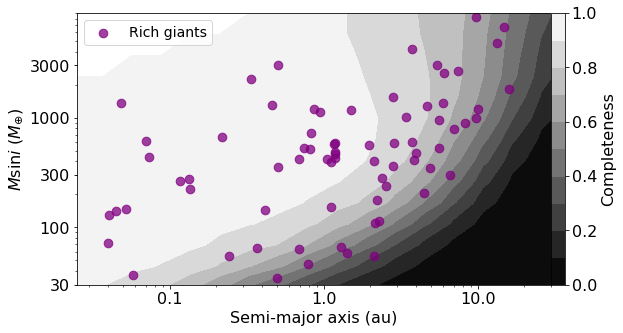

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
matplotlib.rcParams.update({'font.size': 16})

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks((0.1, 1, 10))
ax.set_yticks((30, 100, 300, 1000, 3000))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

CS = ax.contourf(completey_grich.grid[0], completey_grich.grid[1],
                 completey_grich.grid[2], 10, cmap=plt.cm.gray)

ax.scatter(total_spec.query('fe_c > @median_fe_giant').axis, 
           317.8*total_spec.query('fe_c > @median_fe_giant').mass, 
           c='purple', s=75, alpha=0.75, label='Rich giants')

ax.set_xlim([2.5*10**-2, 30])
ax.set_ylim([30, 9000])

ymin, ymax = ax.get_ylim()
ax.set_xlabel('Semi-major axis (au)')
ax.set_ylabel(r'$M$sin$i$ ($M_{\oplus}$)')
ax.legend(fontsize=14)

plt.colorbar(mappable=CS, pad=0, label='Completeness')

fig.savefig('plots/contours_giant_rich.png', dpi=500, bbox_inches='tight')
fig.savefig('plots/contours_giant_rich.pdf', bbox_inches='tight')

In [15]:
objects_list = objects_good.query('hostname not in @bad_names and mass > 0.1')

In [25]:
objects_list = objects_list.sort_values('mass', ascending=False)

In [33]:
objects_list.to_csv('legacy_sorted_mass.csv')

## Look at total planetary mass, rather than multiplicity.

In [16]:
pnames = np.unique(planets.query('mass >= 0.09').hostname) #.query('mass >= 0.1') #objects_list
metals = [np.array(specmatch.query('name == @pname').fe_c)[0] for pname in pnames]
masses = [np.array(specmatch.query('name == @pname').mass_c)[0] for pname in pnames]
tmass  = [np.sum(planets.query('hostname == @pname').mass) for pname in pnames]

In [19]:
bad_names

['114762', '143761', '28185', '42581', '8375', '72659', '167215']

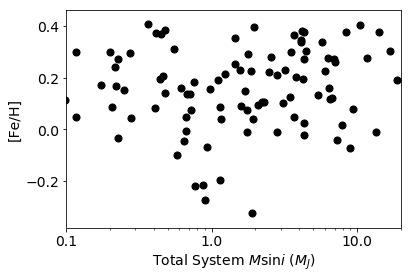

In [56]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(tmass, metals, c='black', s=50)
ax.set_xlabel(r'Total System $M$sin$i$ ($M_J$)')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([0.1, 20])

fig.savefig('plots/metals_vs_totmsini.pdf', bbox_inches='tight')

## Compute Pearson correlation. Basic, then many draws with uncertainty & sini.

In [17]:
def R(x, y):
    return np.sum((x - np.mean(x))*(y - np.mean(y)))/\
           np.sqrt(np.sum((x - np.mean(x))**2)*np.sum((y - np.mean(y))**2))

def devvy(M1, M2):   
    return np.std(np.log10(M1) - np.log10(M2))

In [17]:
R(tmass, metals)

0.11683651088183374

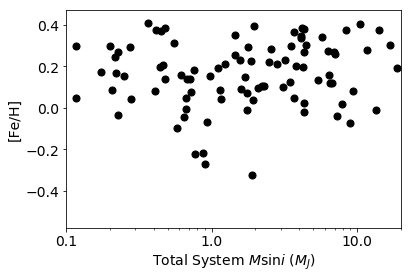

In [42]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.scatter(tmass, metals, c='black', s=50)
ax.set_xlabel(r'Total System $M$sin$i$ ($M_J$)')
ax.set_ylabel('[Fe/H]')
ax.set_xlim([0.1, 20])

fig.savefig('plots/metals_vs_totmsini_os.pdf', bbox_inches='tight')

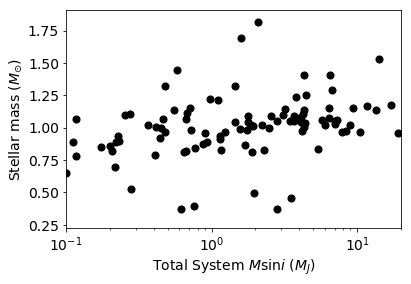

In [99]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.scatter(tmass, masses, c='black', s=50)
ax.set_xlabel(r'Total System $M$sin$i$ ($M_J$)')
ax.set_ylabel(r'Stellar mass ($M_{\odot}$)')
ax.set_xlim([0.1, 20])
#ax.set_ylim([0.5, 1.6])
ax.set_xscale('log')

fig.savefig('plots/smass_vs_totmsini.pdf', bbox_inches='tight')

In [18]:
R(tmass, masses)

0.22534941143999918

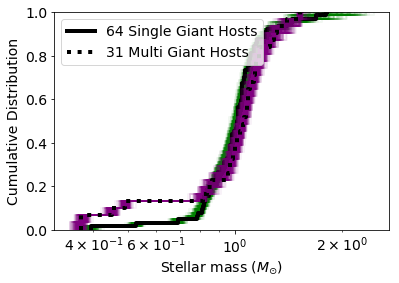

In [70]:
fig, ax = plt.subplots()

smghosts = mghosts.query('mass_c > 0.7')
ssghosts = sghosts.query('mass_c > 0.7')

for i in np.arange(500):
    metals = np.random.normal(sghosts.mass_c, sghosts.mass_err_c)
    solohist, solo_edges = np.histogram(metals, normed=True, bins=5*len(sghosts))
    solochist = np.cumsum(solohist)/np.sum(solohist)
    x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), 
            color='green', lw=2, alpha=0.05, label='_nolegend_')    

solohist, solo_edges = np.histogram(sghosts.mass_c, normed=True, bins=5*len(sghosts))
solochist = np.cumsum(solohist)/np.sum(solohist)
x = np.vstack((solo_edges, np.roll(solo_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((solochist, solochist)).T.flatten(), 0, 0), color='black', lw=4,
        label='{} Single Giant Hosts'.format(len(sghosts)))


for i in np.arange(500):
    metals = np.random.normal(mghosts.mass_c, mghosts.mass_err_c)
    pairhist, pair_edges = np.histogram(metals, normed=True, bins=5*len(mghosts))
    pairchist = np.cumsum(pairhist)/np.sum(pairhist)
    x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
    ax.plot(np.insert(x, 0, x[0]),
            np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), 
            color='purple', lw=2, alpha=0.05, label='_nolegend_')    
    
pairhist, pair_edges = np.histogram(mghosts.mass_c, normed=True, bins=5*len(mghosts))
pairchist = np.cumsum(pairhist)/np.sum(pairhist)
x = np.vstack((pair_edges, np.roll(pair_edges, -1))).T.flatten()[:-2]
ax.plot(np.insert(x, 0, x[0]),
        np.insert(np.vstack((pairchist, pairchist)).T.flatten(), 0, 0), color='black', 
        lw=4, ls=':', label='{} Multi Giant Hosts'.format(len(mghosts)))


#ax.set_xlim([-0.5, 0.5])
ax.set_xscale('log')
ax.set_ylim([0., 1.0])
ax.set_xlabel(r'Stellar mass ($M_{\odot}$)')
ax.set_ylabel('Cumulative Distribution')
ax.legend(loc=2, fontsize=12)

fig.savefig('plots/single_multi_giant_hostmass_cumulative.pdf', bbox_inches='tight')
fig.savefig('plots/single_multi_giant_hostmass_cumulative.png', bbox_inches='tight', dpi=1000)

In [74]:
# Remove low-mass outliers for one version of the comparison, keep for another.
kolmogorovs = []
probs = []
skolmogorovs = []
sprobs = []
for i in np.arange(10**5):
    ssolomasses = np.random.normal(ssghosts.mass_c, ssghosts.mass_err_c)
    smultimasses = np.random.normal(smghosts.mass_c, smghosts.mass_err_c)
    skolmogorov = scipy.stats.ks_2samp(ssolomasses, smultimasses)
    
    solomasses = np.random.normal(sghosts.mass_c, sghosts.mass_err_c)
    multimasses = np.random.normal(mghosts.mass_c, mghosts.mass_err_c)
    kolmogorov = scipy.stats.ks_2samp(solomasses, multimasses)
    
    skolmogorovs.append(skolmogorov[0])
    sprobs.append(skolmogorov[1])
    kolmogorovs.append(kolmogorov[0])
    probs.append(kolmogorov[1])

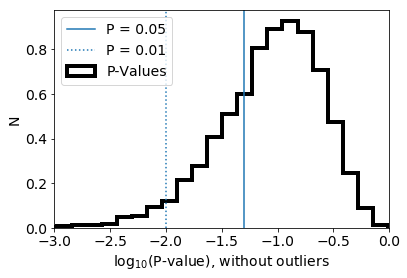

In [85]:
fig, ax = plt.subplots()
ax.hist(np.log10(sprobs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value), without outliers')
ax.set_ylabel('N')
ax.set_xlim([-3, 0])
ax.legend(loc=2, fontsize=12)
fig.savefig('plots/ks_pvalue_single_multi_smass.pdf', bbox_inches='tight')

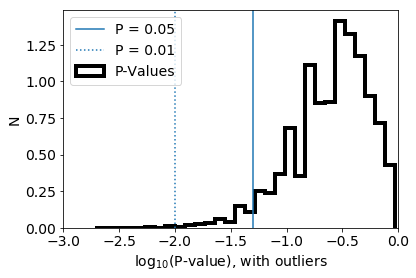

In [86]:
fig, ax = plt.subplots()
ax.hist(np.log10(probs), bins=30, histtype='step', \
        density=True, lw=4, color='black', label='P-Values')
ax.axvline(np.log10(0.05), label='P = 0.05')
ax.axvline(np.log10(0.01), ls=':', label='P = 0.01')
ax.set_xlabel(r'log$_{10}$(P-value), with outliers')
ax.set_ylabel('N')
ax.set_xlim([-3, 0])
ax.legend(loc=2, fontsize=12)
fig.savefig('plots/ks_pvalue_single_multi_mass.pdf', bbox_inches='tight')

In [18]:
pairs = planets.query('mass >= 0.1 and hostname in @multinames')
x = []
y = []
for hostname in pairs.hostname:
    x.append(np.array(pairs.query('hostname==@hostname').mass)[0])
    y.append(np.array(pairs.query('hostname==@hostname').mass)[1])

R(np.log(x), np.log(y))

0.4478550010856209

In [19]:
pairs.to_csv('legacy_giant_pairs.csv')

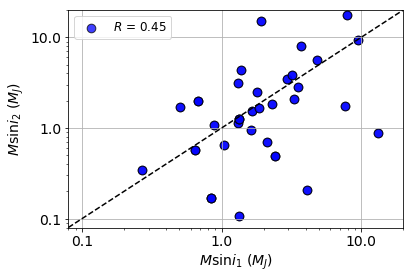

In [30]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
    
ax.scatter(x, y, c='blue', edgecolors='black', alpha=0.75, 
           s=75, linewidth=1, label=r'$R$ = 0.45')

ax.plot(np.linspace(0.08, 20, 20), \
        np.linspace(0.08, 20, 20), 
        ls='--', c='black', label='__nolegend__')
ax.grid()
    
ax.set_xlim([0.08, 20])
ax.set_ylim([0.08, 20])
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$M$sin$i_1$ ($M_J$)')
ax.set_ylabel(r'$M$sin$i_2$ ($M_J$)')

ax.set_xscale('log')
ax.set_xticks((0.1, 1, 10))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.set_yscale('log')
ax.set_yticks((0.1, 1, 10))
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.legend(loc=2, fontsize=12)

fig.savefig('plots/logmsini_correlation.pdf', bbox_inches='tight')

In [18]:
pairs = planets.query('mass >= 0.1 and hostname in @multinames')

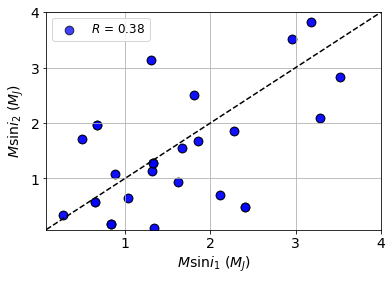

In [34]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})
pairs = planets.query('mass >= 0.1 and hostname in @multinames')
x = []
y = []
for hostname in pairs.hostname:
    x.append(np.array(pairs.query('hostname==@hostname').mass)[0])
    y.append(np.array(pairs.query('hostname==@hostname').mass)[1])
    
ax.scatter(x, y, c='blue', edgecolors='black', alpha=0.75, 
           s=75, linewidth=1, label=r'$R$ = 0.38')

ax.plot(np.linspace(0.08, 20, 20), \
        np.linspace(0.08, 20, 20), 
        ls='--', c='black', label='__nolegend__')
ax.grid()
    
ax.set_xlim([0.08, 4])
ax.set_ylim([0.08, 4])
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlabel(r'$M$sin$i_1$ ($M_J$)')
ax.set_ylabel(r'$M$sin$i_2$ ($M_J$)')

#ax.set_xscale('log')
#ax.set_xticks((0.1, 1, 10))
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

#ax.set_yscale('log')
#ax.set_yticks((0.1, 1, 10))
#ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())

ax.legend(loc=2, fontsize=12)

#fig.savefig('plots/logmsini_correlation.pdf', bbox_inches='tight')

## Randomly sample & measure correlation. Presumably random, let's be sure. With replacement. Lumping triples-and-on in with the pairs.

In [19]:
correlations = []
for i in range(10**5):
    M1 = np.random.choice(pairs.mass, size=int(len(pairs)/2), replace=False)
    M2 = np.random.choice(list(set(pairs.mass) - set(M1)), size=int(len(pairs)/2), replace=False)
    correlations.append(R(np.log(M1), np.log(M2)))

## Now get rid of the triples-and-on, only use the first two giants in each system.

In [20]:
real_pairs = pairs.query('pl_index <= 2') # Imperfect, could cut out small planets, but happens to work.
real_pairs.to_csv('legacy_giant_pairs.csv')

In [56]:
two_correlations = []
for i in range(10**5):
    M1 = np.random.choice(real_pairs.mass, size=int(len(real_pairs)/2), replace=False)
    M2 = np.random.choice(list(set(real_pairs.mass) - set(M1)), size=int(len(real_pairs)/2), replace=False)
    two_correlations.append(R(np.log(M1), np.log(M2)))

In [34]:
np.percentile(correlations, 99.7)

0.4662430392144957

In [57]:
np.percentile(two_correlations, 99.7)

0.4801871733424657

In [63]:
#stats.percentileofscore(correlations, 0.45)
stats.percentileofscore(two_correlations, 0.447855)

99.431

## Now take completeness into account. Sample with replacement.

In [15]:
recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)
axislims = [0.1, 20]
masslims = [30, 6000]
completey_all.completeness_grid([0.9*axislims[0], 1.1*axislims[1]], 
                                [0.9*masslims[0], 1.1*masslims[1]])

In [23]:
complete_correlations = []
complete_devvys = []
a_array = np.array(real_pairs.axis)
m_array = np.array(real_pairs.mass)
indices = np.arange(len(real_pairs))
completeyray = [completey_all.interpolate(a_array[i], m_array[i]) for i in indices]

n = int(len(real_pairs)/2)
for i in range(10**3):
    M1 = []
    M2 = []
    j = 0
    while j < n:
        #one_pair = real_pairs.sample(n=2,replace=False).reset_index(drop=True)
        one_pair = np.random.choice(indices, size=2, replace=False)
        a1, m1 = a_array[one_pair[0]], m_array[one_pair[0]]
        a2, m2 = a_array[one_pair[1]], m_array[one_pair[1]]
        completey1, completey2 = completeyray[one_pair[1]], completeyray[one_pair[1]]
        randy1, randy2 = np.random.uniform(size=2)
        if randy1 <= completey1 and randy2 <= completey2:
            M1.append(m1)
            M2.append(m2)
            j += 1
    complete_correlations.append(R(np.log(M1), np.log(M2)))
    complete_devvys.append(devvy(M1, M2))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161


KeyboardInterrupt: 

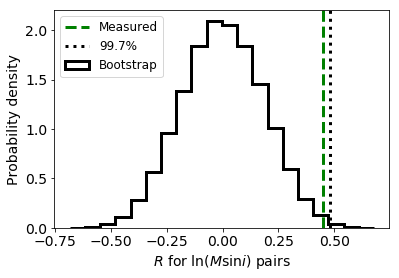

In [59]:
# OLD, SAMPLING WITHOUT REPLACEMENT AND WITHOUT COMPLETENESS
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(two_correlations, histtype='step', color='black', 
        density=True, bins=20, lw=3, label='Bootstrap')
ax.axvline(0.447855, ls='--', color='green', lw=3, label='Measured')
ax.axvline(np.percentile(two_correlations, 99.7), ls=':', 
           lw=3, color='black', label='99.7%')
ax.set_xlabel(r'$R$ for ln($M$sin$i$) pairs')
ax.set_ylabel('Probability density')
ax.legend(fontsize=12)

fig.savefig('plots/bootstrapped_correlation.pdf', bbox_inches='tight')
fig.savefig('plots/bootstrapped_two_correlation.pdf', bbox_inches='tight')

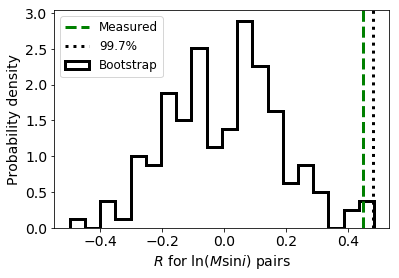

In [25]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(complete_correlations, histtype='step', color='black', 
        density=True, bins=20, lw=3, label='Bootstrap')
ax.axvline(0.447855, ls='--', color='green', lw=3, label='Measured')
ax.axvline(np.percentile(complete_correlations, 99.7), ls=':', 
           lw=3, color='black', label='99.7%')
ax.set_xlabel(r'$R$ for ln($M$sin$i$) pairs')
ax.set_ylabel('Probability density')
ax.legend(fontsize=12)

fig.savefig('plots/bootstrapped_correlation_completeness.pdf', bbox_inches='tight')

## Bootstrap absolute deviation.

In [65]:
logmassratios = []
for index, name in enumerate(giantnames):
    if multistats[index] == 2:
        pair = planets.query('mass >= 0.1 and hostname == @name')
        logmassratios.append(np.log10(np.array(pair.mass)[0]) - \
                             np.log10(np.array(pair.mass)[1]))

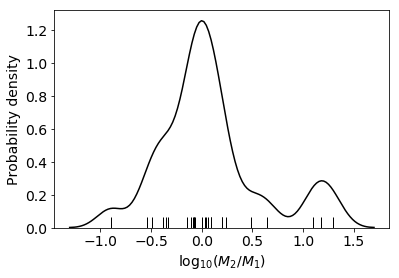

In [72]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots()
#ax.set_xlim([np.amin(logmassratios) - 0.1, np.amax(logmassratios) + 0.1])
ax.set_xlabel(r'log$_{10}$($M_2/M_1$)')
ax.set_ylabel(r'Probability density')
sns.distplot(logmassratios, rug=True, hist=False, kde=True, ax=ax, color='black')
fig.savefig('plots/observed_mass_ratios.pdf', bbox_inches='tight')

In [14]:
def devvy(M1, M2):   
    return np.std(np.log10(M1) - np.log10(M2))

In [61]:
deviations = []
for i in range(50000):
    M1 = np.random.choice(real_pairs.mass, size=int(len(real_pairs)/2), replace=False)
    M2 = np.random.choice(list(set(real_pairs.mass) - set(M1)), size=int(len(real_pairs)/2), replace=False)
    deviations.append(np.std(np.log10(M1) - np.log10(M2)))
    #deviations.append(np.percentile(np.abs(np.log10(M1) - np.log10(M2)), 84.1))

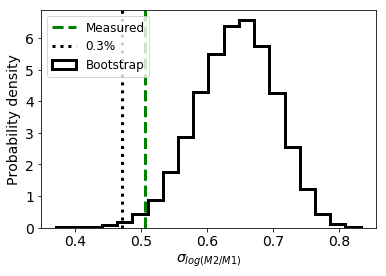

In [62]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(deviations, histtype='step', color='black', 
        density=True, bins=20, lw=3, label='Bootstrap')
ax.axvline(np.std(logmassratios), ls='--', lw=3, color='green', label='Measured')
ax.axvline(np.percentile(deviations, 0.3), ls=':', 
           lw=3, color='black', label='0.3%')
ax.set_xlabel(r'$\sigma_{log(M2/M1)}$')
ax.set_ylabel('Probability density')
ax.legend(fontsize=12, loc=2)

fig.savefig('plots/bootstrapped_deviation.pdf', bbox_inches='tight')

In [67]:
stats.percentileofscore(deviations, np.std(logmassratios))

1.428

## Could there be observational biases that produce an observed correlation? Draw from inferred mass/axis distribution, see if we observe a fake correlation when paired with completeness contours.

## Make it easier, just draw from uniform ln(M)/ln(a) distribution.

In [37]:
nmultisets = len(np.unique(planets_multi.hostname))

In [28]:
recoveries_all = pd.read_csv('../recovery_files/recoveries_all_earth.csv')
completey_all  = Completeness(recoveries_all)
axislims = [0.1, 20]
masslims = [30, 6000]
completey_all.completeness_grid([0.9*axislims[0], 1.1*axislims[1]], 
                                [0.9*masslims[0], 1.1*masslims[1]])

In [22]:
# Pretend distributions are log-uniform. Obviously not true, figure out if it matters.
def draw_pair(completey, axislims=[0.1, 20], masslims=[30, 6000], npairs=100):
    completey.completeness_grid([0.9*axislims[0], 1.1*axislims[1]], 
                                [0.9*masslims[0], 1.1*masslims[1]])
    lnalims = np.log(axislims)
    lnmlims = np.log(masslims)
    pairys = []
    while len(pairys) < npairs:
        lna1, lna2 = np.random.uniform(low=lnalims[0], high=lnalims[1], size=2)  
        lnm1, lnm2 = np.random.uniform(low=lnmlims[0], high=lnmlims[1], size=2)  
        completey1 = completey.interpolate(np.exp(lna1), np.exp(lnm1))
        completey2 = completey.interpolate(np.exp(lna2), np.exp(lnm2))
        randy1, randy2 = np.random.uniform(size=2)
        if randy1 <= completey1 and randy2 <= completey2:
            pairys.append([[lna1, lna2], [lnm1, lnm2]])
    return np.array(pairys)

In [53]:
pairytest = draw_pair(completey_all)

In [57]:
lnmassys = pairytest[:, 1]#np.exp()
R(lnmassys[:, 0], lnmassys[:, 1])

-0.12584139082121984

In [37]:
arrs = []
devs = []
for i in range(50):
    perry = draw_pair(completey_all)
    arrs.append(R(perry[:, 1][:, 0], perry[:, 1][:, 1]))
    devs.append(devvy(perry[:, 1][:, 0], perry[:, 1][:, 1]))

NameError: name 'draw_pair' is not defined

In [69]:
print('R = ', np.median(arrs), '+/-', np.std(arrs))
print('D = ', np.median(devs), '+/-', np.std(devs))

R =  -0.007621084470677373 +/- 0.10238444395116232
D =  0.13720468208565595 +/- 0.01025272884094157


### Recode with split at ice line. 2/11th 0.1--1 au, 9/11ths 1--20 au. 1/4th 0.1--1 au, 4/5th 1--10 au.

In [27]:
# Hard-code the split for now, good enough. Refine it after measuring the exact split.
def draw_pair_split(completey, axislims=[0.1, 20], masslims=[30, 6000], npairs=100):
    lnalims = np.log(axislims)
    lnmlims = np.log(masslims)
    pairys = []
    while len(pairys) < npairs:
        # Pick a random number, decide whether to sample from within or beyond ice line.
        icey1, icey2 = np.random.uniform(low=0, high=1, size=2)
        if icey1 < 2/11:
            lna1 = np.random.uniform(low=lnalims[0], high=0)  
        else:            
            lna1 = np.random.uniform(low=0, high=lnalims[1])  
        if icey2 < 2/11:
            lna2 = np.random.uniform(low=lnalims[0], high=0)  
        else:            
            lna2 = np.random.uniform(low=0, high=lnalims[1])  
        lnm1, lnm2 = np.random.uniform(low=lnmlims[0], high=lnmlims[1], size=2)    
            
        completey1 = completey.interpolate(np.exp(lna1), np.exp(lnm1))
        completey2 = completey.interpolate(np.exp(lna2), np.exp(lnm2))
        randy1, randy2 = np.random.uniform(size=2)
        if randy1 <= completey1 and randy2 <= completey2 and abs(lna1 - lna2 >= 0.5):
            pairys.append([[lna1, lna2], [lnm1, lnm2]])
    return np.array(pairys)

In [29]:
perry = draw_pair_split(completey_all, npairs=1000)

In [38]:
arrs = []
devs = []
for i in range(10000):
    perry = draw_pair_split(completey_all, npairs=nmultisets)
    arrs.append(R(perry[:, 1][:, 0], perry[:, 1][:, 1]))
    devs.append(devvy(np.exp(perry[:, 1][:, 0]), np.exp(perry[:, 1][:, 1])))

In [36]:
arrs

[-0.008624612049501693,
 -0.07555488043970333,
 0.015421295814477931,
 -0.27088749341830487,
 0.10987573374951992,
 -0.09326768555477677,
 0.14717335384204386,
 0.029324709562906524,
 0.03278390567025862,
 0.022171368346598008,
 -0.03280559611402699,
 -0.2639294899013671,
 0.1760596623700374,
 0.3836934820306893,
 0.13816247836727794,
 -0.01169592682452002,
 0.04352200227785529,
 0.11929009203911155,
 -0.04671251503791248,
 -0.14694901310990635,
 -0.08283535257975493,
 -0.20043407264285948,
 -0.22838474078752405,
 -0.03401023927162233,
 -0.20657715908623894,
 -0.11700444168300499,
 0.15403241916992674,
 -0.24189524183174124,
 0.13881601593176926,
 0.24247855210184063,
 0.1875733851372418,
 0.18248453959472385,
 0.10482148252230673,
 0.02295030920399941,
 0.1366869833517428,
 0.19595902889463052,
 -0.18326932542118987,
 -0.03680198847769171,
 -0.11638399950188398,
 -0.15503173899846168,
 0.07967457753131028,
 -0.13653432160048673,
 0.2712360222833987,
 -0.01816572835515872,
 -0.06730094

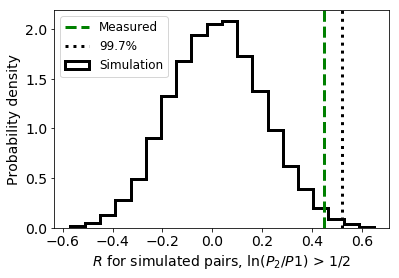

In [41]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.axvline(0.447855, ls='--', lw=3, color='green', label='Measured')
ax.axvline(np.percentile(arrs, 99.7), ls=':', lw=3,
           color='black', label='99.7%')
ax.hist(arrs, histtype='step', color='black', lw=3, 
        density=True, bins=20, label='Simulation')
ax.set_xlabel(r'$R$ for simulated pairs, ln($P_2/P1$) > 1/2')
ax.set_ylabel(r'Probability density')
ax.legend(fontsize=12, loc=2)
fig.savefig('plots/simulated_arr_split.pdf', bbox_inches='tight')

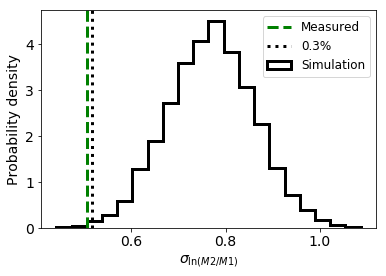

In [42]:
fig, ax = plt.subplots()
matplotlib.rcParams.update({'font.size': 14})

ax.hist(devs, histtype='step', color='black', lw=3,
        density=True, bins=20, label='Simulation')
ax.axvline(np.std(logmassratios), ls='--', lw=3,
           color='green', label='Measured')
ax.axvline(np.percentile(devs, 0.3), ls=':', 
           lw=3, color='black', label='0.3%')
ax.set_xlabel(r'$\sigma_{\mathrm{ln}(M2/M1)}$')# for simulated pairs, ln($P_2/P1$) > 1/2
ax.set_ylabel('Probability density')
ax.legend(fontsize=12, loc=1)

fig.savefig('plots/simulated_deviation_split.pdf', bbox_inches='tight')

In [43]:
stats.percentileofscore(arrs, 0.447855)

98.96

In [44]:
stats.percentileofscore(correlations, 0.447855)

99.605